In [1]:
from __future__ import print_function, division

from keras.datasets import mnist
from keras.layers.merge import _Merge
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, concatenate, Add, Concatenate
from keras.layers import BatchNormalization, Activation, ZeroPadding2D, MaxPooling1D, GlobalAveragePooling1D, MaxPooling2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D, Conv1D,Conv2DTranspose
from keras.models import Sequential, Model
from keras.optimizers import RMSprop,Adam
from functools import partial
import keras.backend as K

import tensorflow as tf

import matplotlib.pyplot as plt
import sys
import numpy as np
import pandas as pd
from scipy.stats import bernoulli
from scipy import stats
from scipy.stats import wasserstein_distance
from functools import partial
from itertools import chain
import seaborn as sns
import random
from sklearn.preprocessing import MinMaxScaler
from scipy import stats

from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage

Using TensorFlow backend.


In [2]:
def get_norm(data):
    mu=data.mean()
    sig=data.std()
    data_n=(data-mu)/sig
    return(data_n,mu,sig)

def get_return(Y):
    R=Y.pct_change()[1:]
    return(R)

    
def split_simple(X,window,roll_w):
    X_true=X.copy()
    L=[]
    
    for k in range(0,X.shape[0],roll_w):
        if k+window<len(X_true):
            L.append(X_true[k:k+window])
        else:
            break
    return(L)
    

def mmd(x1, x2, beta=1.0):
    x1x1 = gaussian_kernel(x1, x1, beta)
    x1x2 = gaussian_kernel(x1, x2, beta)
    x2x2 = gaussian_kernel(x2, x2, beta)
    diff = x1x1.mean() - 2 * x1x2.mean() + x2x2.mean()
    return diff

def gaussian_kernel(x1, x2, beta = 1.0):
    r = x1.dimshuffle(0,'x',1)
    return K.exp( -beta * K.square(r - x2).sum(axis=-1))



## Data processing

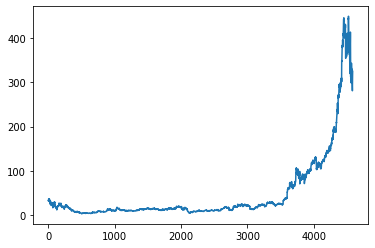

In [3]:
data_sp=pd.read_csv('prixSPX')
data_sp.head(2)    

prices=data_sp
prices_clean=prices.dropna(axis=1)
prices_clean.columns=[str(i) for i in range(115)]
prices_clean.index=prices_clean['0']

prix=prices_clean[[str(i) for i in range(1,50)]]
del prices_clean['0']
prix.shape

N_actif=6
prix_a=np.array(prix)[:,1:N_actif+1]
prix_a.shape
plt.plot(prix_a[:,1])

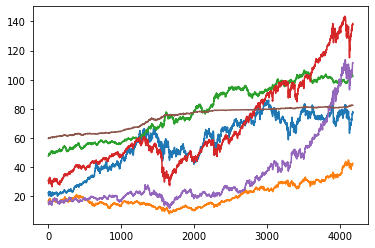

In [4]:
#diversified portfolio 
apple=pd.read_csv('AAPL.csv',index_col='Date',parse_dates=True)
apple=apple['Adj Close']

xom=pd.read_csv('XOM.csv',index_col='Date',parse_dates=True)
xom=xom['Adj Close']

pfe=pd.read_csv('PFE.csv',index_col='Date',parse_dates=True)
pfe=pfe['Adj Close']

ief=pd.read_csv('IEF.csv',index_col='Date',parse_dates=True)
ief=ief['Adj Close']

iyy=pd.read_csv('IYY.csv',index_col='Date',parse_dates=True)
iyy=iyy['Adj Close']

msft=pd.read_csv('MSfT.csv',index_col='Date',parse_dates=True)
msft=msft['Adj Close']

shy=pd.read_csv('shy.csv',index_col='Date',parse_dates=True)
shy=shy['Adj Close']

df_prix=pd.concat([apple,xom,pfe,ief,iyy,msft,shy],axis=1)
df_prix.columns=['apple','exone','pfizer','treasury10','downjones','microsoft','tresury3']
df_prix=df_prix.dropna(axis=0)

apple.head()
#df_prix.plot()


prix_a=np.array(df_prix)[:,1:]
plt.plot(prix_a)


N_actif=prix_a.shape[1]
var_prix=get_return(pd.DataFrame(prix_a)).cov()
sig_prix=get_return(pd.DataFrame(prix_a)).std()

(4137, 6)


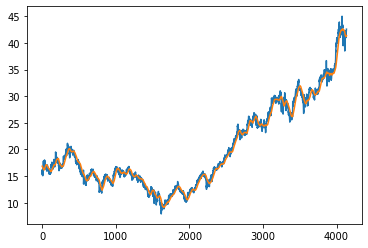

In [5]:
w=40
df_prix=pd.DataFrame(prix_a)
roll_data=df_prix.rolling(w).mean()
roll_data=roll_data.dropna()
print(roll_data.shape)
roll_data_a=np.array(roll_data)
prix_a_c=prix_a[w:]
plt.plot(prix_a_c[:,1])
plt.plot(roll_data_a[:,1])

In [6]:
#PF Jiali 1
df_pf1=pd.read_excel('PF.xlsx', sheetname='Ptf_1',index_col='END DATE',parse_dates=True)
del df_pf1['Equity_EM']



C:\Users\rochej\AppData\Local\Continuum\anaconda3\envs\ml_env\lib\site-packages\pandas\util\_decorators.py:188: FutureWarning: The `sheetname` keyword is deprecated, use `sheet_name` instead
  return func(*args, **kwargs)


In [7]:
prix_a=np.array(df_pf1)
N_actif=prix_a.shape[1]
var_prix=get_return(pd.DataFrame(prix_a)).cov()
sig_prix=get_return(pd.DataFrame(prix_a)).std()

In [8]:
prix_a_test=prix_a[3826:]
heatMap(get_return(pd.DataFrame(prix_a)))

NameError: name 'heatMap' is not defined

In [79]:
#rebalancement validé f=20,8
b=40
f=20
w=b+f
k=N_actif
input_shape=(b,k)
kernel_length=5
batch_size=32

def build_generator():
    #conditionning
    model_c = Sequential()
    model_c.add(Conv1D(k, kernel_length, strides=2, activation='relu', input_shape=(b, k),padding='same'))
    model_c.add(Conv1D(k, kernel_length, strides=2, activation='relu',padding='same'))
    model_c.add(Conv1D(k, kernel_length, strides=2, activation='relu',padding='same'))
    model_c.add(Conv1D(k, kernel_length, strides=2, activation='relu',padding='same'))
    model_c.add(Flatten())
    model_c.add(Dense(k, activation='relu'))
    model_c.add(Reshape((1,k)))
    print(model_c.summary())
    
    M_b_tensor=Input(shape=(b,k),name='M_b_real')
    output_conv = model_c(M_b_tensor)
    
    noise_tensor=Input(shape=(1,2*k))
    #A_tensor=Input(shape=(1,k))
    
    output_final_c=concatenate([output_conv,noise_tensor])
    
    #simulator
    model_s = Sequential()
    model_s.add(Dense(f*k, activation='relu',input_shape=(3*k,)))
    model_s.add(Reshape((int(f/4), int(4*k))))
    model_s.add(Reshape(( -1, int(f/4),int(4*k))))
    model_s.add(Conv2DTranspose(int(2*k),kernel_size=(1,5),strides=(1,2),padding='same'))
    model_s.add(Conv2DTranspose(int(k),kernel_size=(1,5),strides=(1,2),padding='same'))
    model_s.add(Reshape((int(f), int(k))))
    model_s.summary()
    
    output_final_gene=model_s(output_final_c)
    
    
    
    return(Model([M_b_tensor,noise_tensor], output_final_gene)) 

build_generator()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_19 (Conv1D)           (None, 20, 10)            510       
_________________________________________________________________
conv1d_20 (Conv1D)           (None, 10, 10)            510       
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 5, 10)             510       
_________________________________________________________________
conv1d_22 (Conv1D)           (None, 3, 10)             510       
_________________________________________________________________
flatten_5 (Flatten)          (None, 30)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 10)                310       
_________________________________________________________________
reshape_9 (Reshape)          (None, 1, 10)             0         
Total para

In [80]:
def build_discriminator():
    #convolutions
    model_d = Sequential()
    model_d.add(Conv1D(2*k, kernel_length, strides=2, input_shape=(f+b, k),padding='same'))
    model_d.add(LeakyReLU(0.2))
    model_d.add(Conv1D(2*2*k, kernel_length, strides=2,padding='same'))
    model_d.add(LeakyReLU(0.2))
    model_d.add(Conv1D(2*2*2*k, kernel_length, strides=2,padding='same'))
    model_d.add(LeakyReLU(0.2))
    model_d.add(Conv1D(2*2*2*2*k, kernel_length, strides=2,padding='same'))
    model_d.add(LeakyReLU(0.2))
    model_d.add(Conv1D(2*2*2*2*2*k, kernel_length, strides=2,padding='same'))
    model_d.add(LeakyReLU(0.2))
    model_d.add(Flatten())
    print(model_d.summary())
    
    M_tensor=Input(shape=(b+f,k),name='M_real')
    #A_tensor=Input(shape=(k,))
    
    output_conv_disc=model_d(M_tensor)
    #input_dense=concatenate([output_conv_disc,A_tensor])
    input_dense=output_conv_disc
    
    #last dense layer
    model_dense=Sequential()
    model_dense.add(Dense(1))
    #derniere modif
    model_dense.add(Activation("linear"))
    #model_dense.add(LeakyReLU(0.2))
    
    
    output_final_discr=model_dense(input_dense)
    print(model_dense.summary())
    
    return(Model([M_tensor], output_final_discr))

build_discriminator()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_23 (Conv1D)           (None, 30, 20)            1020      
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 30, 20)            0         
_________________________________________________________________
conv1d_24 (Conv1D)           (None, 15, 40)            4040      
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 15, 40)            0         
_________________________________________________________________
conv1d_25 (Conv1D)           (None, 8, 80)             16080     
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 8, 80)             0         
_________________________________________________________________
conv1d_26 (Conv1D)           (None, 4, 160)            64160     
__________

### Remarque:

1. Le discriminateur cherche à maximiser la EM-1 distance contrairement au GAN ou le dicriminateur renvoie une proba comprise entre 0 et 1. Dans l model classique, le GAN est penalisé quand le proba d'une fake image diffère de la proba d'une vrai image. Le discrimanteur est alors un binary classifier
1. Dans le WGAN: l'output du discriminateur est un scalaire (c'est un réelle): correspond au "score" d'un fake ou real data. 
1. Avec Kerzs, Wassetein distance pas calculer directement: Loss: la formule est ok seulement si on labelise -1 pour les generated et 1 for the real. Avec ce labelling, on a donc (https://machinelearningmastery.com/how-to-implement-wasserstein-loss-for-generative-adversarial-networks/):
    * loss_discriminator = - 1 * disc_real + 1 * disc_fake
    * loss_generator = - 1 * disc_fake (since the generator only updates on fake images)
1. A noter que dans le train_on_batch, le discr ou gene ne cherche pas à fitter avec les labels. Le role du discrimnateur n'est plus de classifier mais d'attribuer des "scores" les plus eloignées l'un de l'autre entre fake et real. 
2. wassertein loss can be track during the training process. It is not the case for classic GAN. the generator loss in GAN does not drop even the image quality improves. (https://medium.com/@jonathan_hui/gan-wasserstein-gan-wgan-gp-6a1a2aa1b490)
3. GAN discriminator very different (in terms of concept) form WGAN discriminator https://medium.com/@kion.kim/wgan-and-wgan-gp-2798d065a2db

In [81]:
class RandomWeightedAverage(_Merge):
    """Provides a (random) weighted average between real and generated data samples"""
    def _merge_function(self, inputs):
        alpha = K.random_uniform((batch_size,w,k)) #(batch_size,col,1)
        return (alpha * inputs[0]) + ((1 - alpha) * inputs[1])

def gradient_penalty_loss(y_true, y_pred, averaged_samples):
    #Computes gradient penalty based on prediction and weighted real / fake samples 
    gradients=K.gradients(y_pred, averaged_samples)[0]
        # compute the euclidean norm by squaring ...
    gradients_sqr = K.square(gradients)
        #   ... summing over the rows ...
    gradients_sqr_sum = K.sum(gradients_sqr,
                              axis=np.arange(1, len(gradients_sqr.shape)))
        #   ... and sqrt
    gradient_l2_norm = K.sqrt(gradients_sqr_sum)
        # compute lambda * (1 - ||grad||)^2 still for each single sample
    gradient_penalty = K.square(1 - gradient_l2_norm)
        # return the mean as loss over all the batch samples
    return K.mean(gradient_penalty)  

def wasserstein_loss(y_true,y_pred):
    return K.mean(y_true * y_pred)

def get_A_tensor(M):
    tensor_min=K.min(M,axis=1)
    tensor_max=K.max(M,axis=1)
    tensor_mean=K.mean(M,axis=1)
    #result=Lambda(lambda x: (x[0]-x[1])/x[2])([tensor_max,tensor_min,tensor_mean])
    result=(tensor_max-tensor_min)/tensor_mean
    return(result)
    
    

In [82]:
optimizer = Adam(lr=0.00005,beta_1=0.5)

generator = build_generator()
discriminator=build_discriminator()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_28 (Conv1D)           (None, 20, 10)            510       
_________________________________________________________________
conv1d_29 (Conv1D)           (None, 10, 10)            510       
_________________________________________________________________
conv1d_30 (Conv1D)           (None, 5, 10)             510       
_________________________________________________________________
conv1d_31 (Conv1D)           (None, 3, 10)             510       
_________________________________________________________________
flatten_7 (Flatten)          (None, 30)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 10)                310       
_________________________________________________________________
reshape_13 (Reshape)         (None, 1, 10)             0         
Total para

## Graph for the discriminator

In [83]:
generator.trainable = False
M_b_real = Input(shape=(b,k),name='M_b_t')
#A_b_real=Input(shape=(1,k))
noise = Input(shape=(1,2*k),name='noise_1')

M_f_fake = generator([M_b_real,noise])

M_real= Input(shape=(w,k),name='M_real_t')
#A_big_real=Input(shape=(k,))
M_fake= Concatenate(axis=1)([M_b_real, M_f_fake])
#A_big_fake=Input(shape=(k,))
#A_big_fake=get_A_tensor(M_fake)

fake = discriminator([M_fake])
valid = discriminator([M_real])

interpolated_data = RandomWeightedAverage()([M_real, M_fake])
#A_interpolated=Input(shape=(k,))
#A_interpolated=get_A_tensor(interpolated_data)
validity_interpolated = discriminator([interpolated_data])
partial_gp_loss = partial(gradient_penalty_loss,averaged_samples=interpolated_data)
partial_gp_loss.__name__ = 'gradient_penalty'

#3 outputs: 1 from the real , the fake and average/interpolate data
#loss minimizzed: weigthed sum taking as argument the 3 outputs
discriminator_model=Model(inputs=[M_b_real,M_real, noise], outputs=[valid, fake, validity_interpolated])
discriminator_model.compile(loss=[wasserstein_loss, wasserstein_loss, partial_gp_loss],optimizer=optimizer, loss_weights=[1, 1, 10])

## Graph for the generator

In [84]:
discriminator.trainable = False
generator.trainable = True

noise_gene=Input(shape=(1,2*k),name='noise_gene')
M_b_real_gene = Input(shape=(b,k),name='M_b_real_gene')
#A_real_gene=Input(shape=(1,k))

M_f_gene=generator([M_b_real_gene,noise_gene])

M_gene= Concatenate(axis=1)([M_b_real_gene, M_f_gene])
#A_big_real_2=Input(shape=(k,))
valid = discriminator([M_gene])

generator_model = Model([noise_gene,M_b_real_gene], valid)
generator_model.compile(loss=wasserstein_loss, optimizer=optimizer)


In [85]:
scaler = MinMaxScaler(feature_range=(-1, 1))

def get_diff_array_to_array(P):
    ret_n=pd.DataFrame(P).diff()
    ret_n=ret_n.dropna(axis=0)
    ret_n_a=np.array(ret_n)
    return(ret_n_a)

def get_long_tail(data):
    p_min=data.min(axis=0)
    p_max=data.max(axis=0)
    p_mean=data.mean(axis=0)
    return((p_max-p_min)/p_mean)
    

#### creation dataset: overlapping pour creer les inputs: definition d'une fenetre de roulement

In [86]:
#i w=, a chaque data, on peut associé une matrice de taille 60 
w_roll=1

def split(X,w,roll_w):
    X_true=X.copy()
    R_true=np.array(get_return(pd.DataFrame(X_true)))
    X_n=scaler.fit_transform(X_true)
    X_diff=get_diff_array_to_array(X_n)
    P_last_true=[]
    R_last_true=[]
    L_n=[]
    L=[]
    L_b=[]
    L_f=[]
    A_b=[]
    A=[]
    prix_a_split=[]
    list_avg=[]
    
    for k in range(0,X_diff.shape[0],roll_w):
        if k+w<len(X_true):
            prix_a_split.append(X_true[k:k+w])
            list_avg.append(np.mean(X_true[k:k+b],axis=0))
            P_last_true.append(X_true[k+w-1])
            R_last_true.append(R_true[k+w-1])
            L_n.append(X_n[k:k+w])
            L.append(X_diff[k:k+w])
            L_b.append(X_diff[k:k+b])
            L_f.append(X_diff[k+b:k+b+f])
            
            data_b=X_true[k:k+b]
            data=X_true[k:k+w]
            A_b.append(get_long_tail(data_b))
            A.append(get_long_tail(data))
            
        else:
            break
    
    return(L,L_b,L_f,A,A_b,L_n,P_last_true,R_last_true,prix_a_split,list_avg)

#creation des inputs general: train+test
L,L_b,L_f,A,A_b,L_n,P_last_true,R_last_true,prix_a_split,list_avg=split(prix_a,w,w_roll)

int(0.8*4530)
prix_a_split[0].shape

(60, 10)

In [87]:
#split train and test data set
N_train=int(0.8*4530)
#N_train=3826
L_train,L_b_train,L_f_train,L_n_train,A_b_train,P_last_true_train,prix_a_split_train=L[:N_train],L_b[:N_train],L_f[:N_train],L_n[:N_train],A_b[:N_train],P_last_true[:N_train],prix_a_split[:N_train]
L_test,L_b_test,L_f_test,L_n_test,A_b_test,P_last_true_test,prix_a_split_test=L[N_train:],L_b[N_train:],L_f[N_train:],L_n[N_train:],A_b[N_train:],P_last_true[N_train:],prix_a_split[N_train:]

list_avg_train=list_avg[:N_train]
list_avg_test=list_avg[N_train:]

In [88]:
#melange de la dataset de train 
#zipping the lsit
c=list(zip(L_train,L_b_train,L_f_train,L_n_train,A_b_train,P_last_true_train))
random.shuffle(c)
#unzipping the list: L_s: suffled list
L_train_s,L_b_train_s,L_f_train_s,L_n_train_s,A_b_train_s,P_last_true_train_s=zip(*c)


In [89]:
print(len(L_train_s))
L_b_train_s[10].shape
len(L_test)

3624


1187

In [90]:
p_true=np.array(P_last_true)
r_true=np.array(R_last_true)
print(r_true.shape)



R=np.array(get_return(pd.DataFrame(prix_a)))
L_r=split_simple(R,w,w_roll)
len(L_r)

(4811, 10)


4810

## Train

train on suffled train data set

In [91]:
n_critic = 5
iterations=2000
#labels used for loss computation:
valid = -np.ones((batch_size, 1))
fake =  np.ones((batch_size, 1))
dummy = np.zeros((batch_size, 1)) 

start = 0
num_train=len(L_train)
for step in range(iterations):
    #suffle lists
    c=list(zip(L_train,L_b_train,L_f_train,L_n_train,A_b_train,P_last_true_train))
    random.shuffle(c)
    L_train_s,L_b_train_s,L_f_train_s,L_n_train_s,A_b_train_s,P_last_true_train_s=zip(*c)
    for _ in range(n_critic):
        stop = start + batch_size
        #sous forme diff
        M_batch = np.array(L_train_s[start:stop])
        M_b_batch=np.array(L_b_train_s[start:stop])
        noise=np.random.uniform(low=-1.0,high=1.0, size=(batch_size,1,2*k))
        
        d_loss = discriminator_model.train_on_batch([M_b_batch,M_batch, noise],[valid, fake, dummy])#return training loss
        
    g_loss = generator_model.train_on_batch([noise,M_b_batch],valid)
    start += batch_size
    if start > num_train - batch_size:
        start = 0
    if step % 10 == 0:
        print(step)
        print(d_loss[-1],d_loss[0],d_loss[1])
        print(g_loss)

        
        

C:\Users\rochej\AppData\Local\Continuum\anaconda3\envs\ml_env\lib\site-packages\keras\engine\training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
C:\Users\rochej\AppData\Local\Continuum\anaconda3\envs\ml_env\lib\site-packages\keras\engine\training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0
0.82525337 8.250615 0.00034440146
0.0026046673


C:\Users\rochej\AppData\Local\Continuum\anaconda3\envs\ml_env\lib\site-packages\keras\engine\training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


10
0.035406437 0.27843213 -0.010808481
0.06735295
20
0.012340795 0.018696688 -0.02790394
0.07820395
30
0.013611734 -0.009955555 -0.044374373
0.102820635
40
0.0051806606 -0.13652769 -0.05452379
0.13489817
50
0.0043217354 -0.18383294 -0.07958024
0.14976086
60
0.00435208 -0.22498325 -0.09956587
0.17113255
70
0.0029538309 -0.2991301 -0.12250091
0.2086965
80
0.0028167965 -0.35376644 -0.14343144
0.24055956
90
0.0014556701 -0.43230817 -0.16275793
0.28911904
100
0.0042490656 -0.42812568 -0.1771972
0.29282188
110
0.0020723937 -0.43137482 -0.17146137
0.28079107
120
0.0026778448 -0.43700874 -0.17072067
0.2918956
130
0.0024421432 -0.41722608 -0.1651442
0.27726242
140
0.002161838 -0.3969198 -0.16664742
0.25089577
150
0.0018247197 -0.3682428 -0.15722488
0.22933172
160
0.0017425825 -0.35254622 -0.14443047
0.22399615
170
0.0014830176 -0.36348888 -0.14082007
0.23853067
180
0.001288028 -0.32641882 -0.14628421
0.19350871
190
0.001994625 -0.32180038 -0.14515233
0.19505873
200
0.0014296303 -0.30977097 -0.1

1580
0.0007425187 -0.01753986 0.28495887
0.30970386
1590
0.0007144111 -0.018588169 0.28416947
0.3088239
1600
0.000558997 -0.023324303 0.3032131
0.3299563
1610
0.0008555468 -0.022150252 0.29305577
0.32682958
1620
0.0007351385 -0.010504974 0.2995682
0.318885
1630
0.0013270588 -0.010203867 0.26891568
0.29374054
1640
0.00068921945 -0.014750013 0.26859018
0.2904979
1650
0.0008577444 -0.015861355 0.27953097
0.30604148
1660
0.0004607854 -0.021280767 0.2794743
0.30807707
1670
0.0005509854 -0.01374805 0.28327143
0.3050798
1680
0.0006429609 -0.018605534 0.28023335
0.3083637
1690
0.00044383906 -0.02273021 0.25663188
0.27845553
1700
0.0010179183 -0.018958308 0.25601682
0.28459966
1710
0.0011310903 -0.015499147 0.2565477
0.28415015
1720
0.0008672076 -0.015759956 0.27777493
0.2985042
1730
0.0005213451 -0.014630366 0.26573896
0.28843924
1740
0.0007207219 -0.01721051 0.27252737
0.30140257
1750
0.0012535016 -0.016354788 0.2787082
0.30536768
1760
0.0005431285 -0.024635414 0.3034656
0.3330051
1770
0.0010

#### Train data set test

In [22]:
noise_test=np.random.uniform(low=-1.0,high=1.0, size=(batch_size,1,2*k))
data_test=L_b[0].reshape(1,L_b[0].shape[0],L_b[0].shape[1])
ret_gene=generator.predict([data_test,noise_test])
ret_gene.shape

(1, 8, 10)

In [23]:
f=8

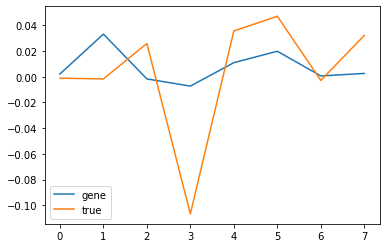

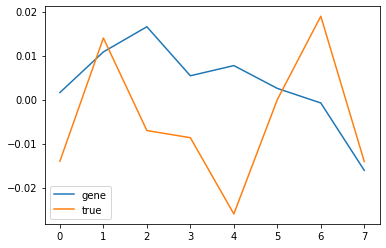

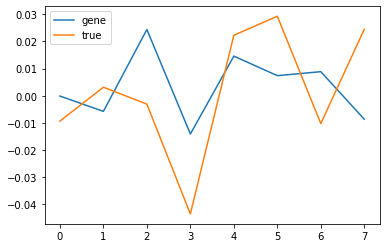

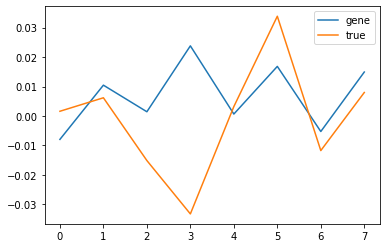

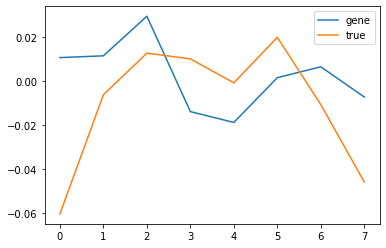

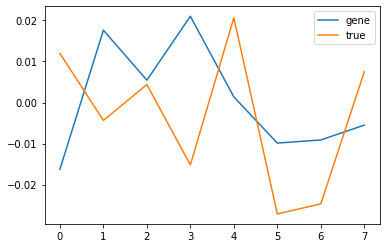

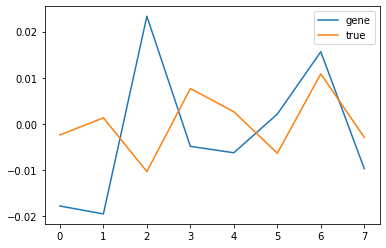

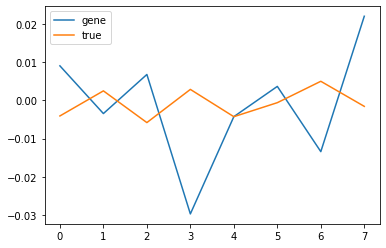

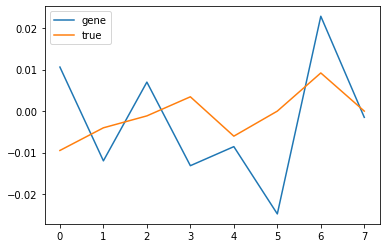

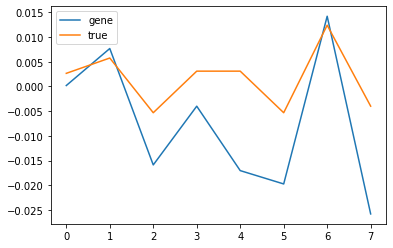

In [24]:
noise_test=np.random.uniform(low=-1.0,high=1.0, size=(batch_size,1,2*k))
data_test=L_b[0].reshape(1,L_b[0].shape[0],L_b[0].shape[1])
ret_gene=generator.predict([data_test,noise_test])
ret_gene_f=ret_gene.reshape(f,N_actif)
ret_true=L_f[0]
for i in range(N_actif):
    plt.figure()
    plt.plot(ret_gene_f[:,i],label='gene')
    plt.plot(ret_true[:,i],label='true')
    plt.legend()

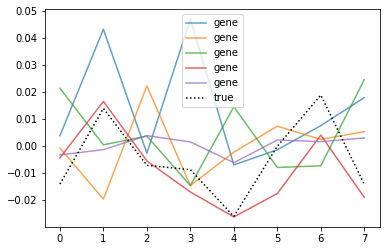

In [25]:

N_sim=5
data=L_b[0]
k=N_actif
#data_test=data.reshape(1,data.shape[0],data.shape[1])
data_test=L_b[0].reshape(1,L_b[0].shape[0],L_b[0].shape[1])
noise_test=np.random.uniform(low=-1.0,high=1.0, size=(N_sim,1,2*k))
ret_true=L_f[0]
for i in range(N_sim):
    noise_t=noise_test[i]
    noise_t=noise_t.reshape(1,1,2*N_actif)
    ret_gene=generator.predict([data_test,noise_t])
    ret_gene_f=ret_gene.reshape(f,N_actif)
    plt.plot(ret_gene_f[:,1],label='gene',alpha=0.7)
    
plt.plot(ret_true[:,1],label='true',color='black',linestyle=':')
plt.legend()
    

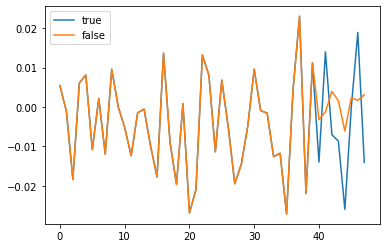

In [26]:
#data normalisées
data_true=L[0]
data_fake=np.vstack((L_b[0],ret_gene_f))
plt.plot(data_true[:,1],label='true')
plt.plot(data_fake[:,1],label='false')
plt.legend()

In [27]:
print(discriminator.predict(data_true.reshape(1,b+f,N_actif)))
print(discriminator.predict(data_fake.reshape(1,b+f,N_actif)))

[[-0.0315048]]
[[-0.05931032]]


In [28]:
def get_price(p_ini,R):
    s=p_ini+np.cumsum(R,axis=0)
    prix=np.insert(s,0,p_ini,axis=0)
    return(prix)

def denomalize(p_ini,R):
    prix_n=get_price(p_ini,R)
    prix=scaler.inverse_transform(prix_n)
    prix=prix[0:prix.shape[0]-1]
    return(prix)



In [29]:
p_ini=L_n[0][0]
df_test=denomalize(p_ini,data_true)
L_n[0][0].shape


(10,)

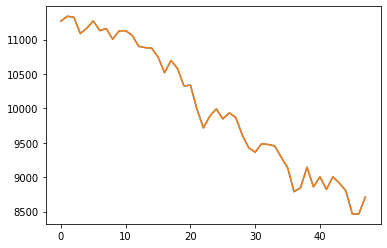

In [30]:
plt.plot(df_test[:,1])
plt.plot(prix_a[0:f+b,1])


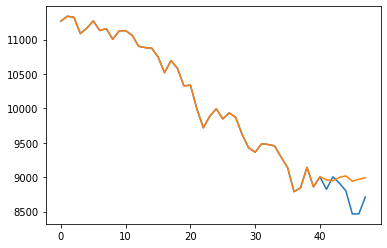

In [31]:
df_fake=denomalize(p_ini,data_fake)
plt.plot(prix_a[0:f+b,1])
plt.plot(df_fake[:,1])


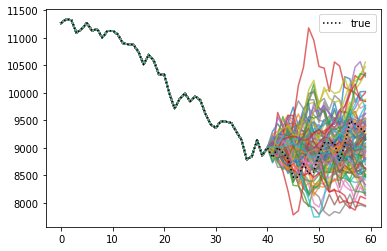

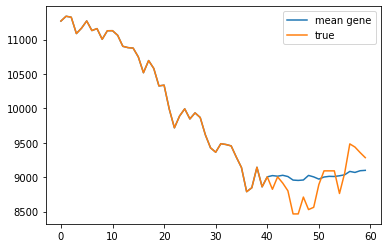

In [92]:

N_sim=100

k=N_actif


def simulate_prix(N_sim,data_b,data_f,data_n,data_real,avg):
    
    #data_test=data.reshape(1,data.shape[0],data.shape[1])
    data_test=data_b.reshape(1,data_b.shape[0],data_b.shape[1])
    noise_test=np.random.uniform(low=-1.0,high=1.0, size=(N_sim,1,2*k))
    ret_true=data_f
    M=[]
    S=np.zeros((N_sim,w,k))
    D_output_fake=[]
    for i in range(N_sim):
        noise_t=noise_test[i]
        noise_t=noise_t.reshape(1,1,2*N_actif)
        ret_gene=generator.predict([data_test,noise_t])
        ret_gene_f=ret_gene.reshape(f,N_actif)

        data_fake=np.vstack((data_b,ret_gene_f))
        p_ini=data_n[0]
        df_fake=denomalize(p_ini,data_fake)
        M.append(pd.DataFrame(df_fake[:,1]))
        S[i]=df_fake

        out_fake=discriminator.predict(df_fake.reshape(1,f+b,N_actif))
        D_output_fake.append(float(out_fake))


        plt.plot(df_fake[:,1],alpha=0.7)
        #plt.hlines(avg[1],0,w,linestyle=':',color='red')

    #plt.plot(prix_a[0:f+b,1],label='true',color='black',linestyle=':')
    plt.plot(data_real[:,1],color='black',linestyle=':',label='true')
    plt.legend()
    plt.savefig('result/sim1.pdf')

    #output_true=float(discriminator.predict(prix_a[0:f+b].reshape(1,f+b,6)))
    #print(output_true)

    plt.figure()
    signal_moy=np.mean(S,axis=0)
    plt.plot(signal_moy[:,1],label='mean gene')
    plt.plot(data_real[:,1],label='true')
    #plt.hlines(avg[1],0,w,linestyle=':',color='red')
    plt.legend()
    plt.savefig('result/sim1m.pdf')
    
    return(signal_moy)
    
signal_moy=simulate_prix(N_sim,L_b[0],L_f[0],L_n[0],prix_a_split_train[0],list_avg[0])


In [131]:
prix_a_split_train[0].shape
r_data=get_return(pd.DataFrame(prix_a_split_train[0]))
m_data=r_data.mean(axis=0)
m_data
sig_data=r_data.std(axis=0)
print(sig_data)
np.random.normal(m_data,sig_data,(8,6)).shape



0    0.017756
1    0.017021
2    0.013699
3    0.016749
4    0.022762
5    0.004373
6    0.003424
7    0.002189
8    0.002598
9    0.003336
dtype: float64


ValueError: shape mismatch: objects cannot be broadcast to a single shape

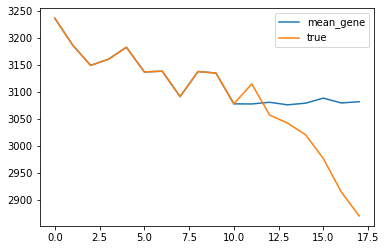

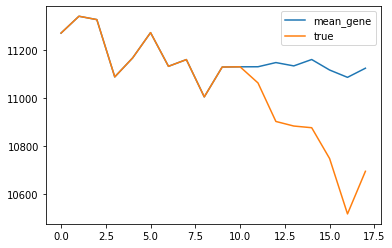

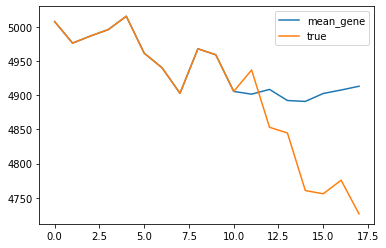

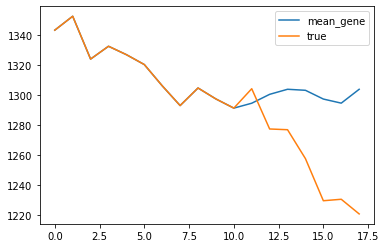

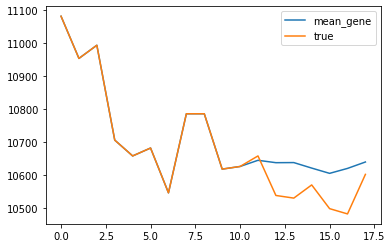

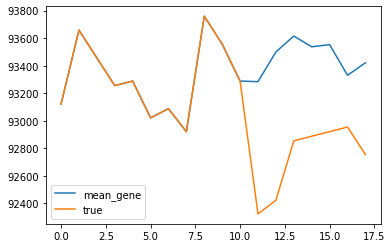

In [179]:
num_dim=3
for p in range(6):
    plt.figure()
    plt.plot(signal_moy[:,p],label='mean_gene')
    plt.plot(prix_a[0:f+b,p],label='true')
    plt.legend()

## Wassertein distance test

In [64]:
D_a=np.array(D_output_fake)
output_mean=np.mean(D_a)
x_sim=np.array([i for i in range(1,N_sim+1)])
plt.scatter(x_sim,D_a)
plt.hlines(output_true,0,100)
plt.hlines(output_mean,0,100,color='red')

NameError: name 'D_output_fake' is not defined

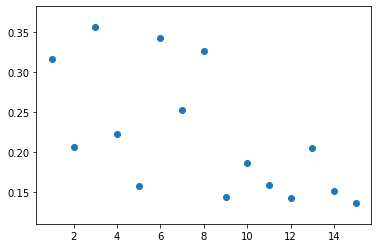

In [65]:
n_1=np.random.normal(0,1,60)
n_2=np.random.normal(0,1,60)
n_3=np.random.normal(0,1,60)

D_wass=[]
x_sim=np.array([i for i in range(1,N_sim+1)])
for j in range(N_sim):
    n_2=np.random.normal(0,1,60)
    D_wass.append(wasserstein_distance(n_1, n_2))
D_wass_a=np.array(D_wass)
plt.scatter(x_sim,D_wass_a)
    
    

#### Test on dataset test

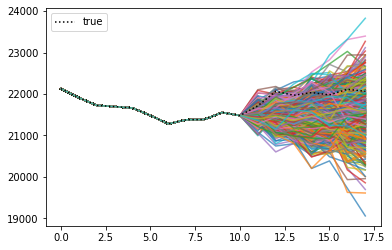

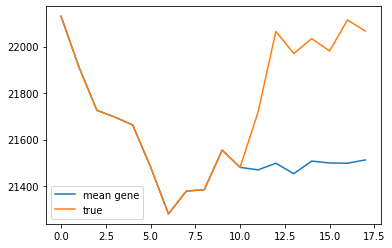

In [180]:
indice=50
a=simulate_prix(1000,L_b_test[indice],L_f_test[indice],L_n_test[indice],prix_a_split_test[indice],list_avg_test[indice])


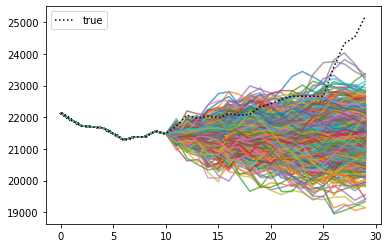

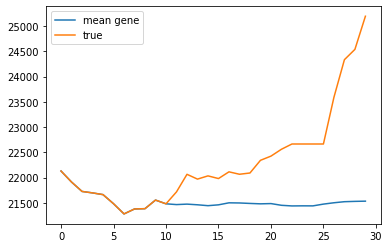

In [143]:
indice=50
a=simulate_prix(1000,L_b_test[indice],L_f_test[indice],L_n_test[indice],prix_a_split_test[indice],list_avg_test[indice])

#### Test on train dataset

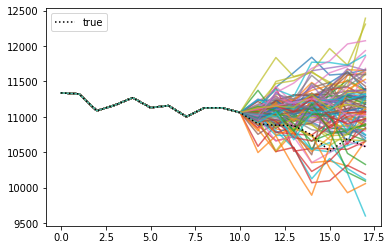

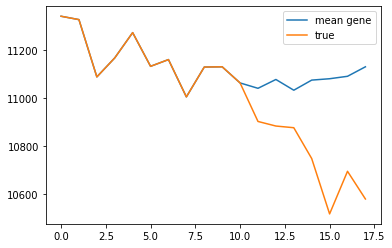

In [181]:
indice=1
a=simulate_prix(N_sim,L_b_train[indice],L_f_train[indice],L_n_train[indice],prix_a_split_train[indice],list_avg_train[indice])

### gaussian simulation
multi gaussian ou std

In [33]:
def get_price_prod(p_ini,R):
    s=p_ini*np.cumprod((R+1),axis=0)
    prix=np.insert(s,0,p_ini,axis=0)
    return(prix)

In [93]:
#simulate under the hypothesis that return are normaly distributed
dim_aff=1
f=20
b=40
w=b+f
def gaussian_simulate(N_sim,data_real):
    r_data=get_return(pd.DataFrame(data_real))
    r_data_a=np.array(r_data)
    m_data=r_data.mean(axis=0)
    Sig=r_data.cov()
    sig_data=r_data.std(axis=0)
    #sig_data=data_real.std(axis=0)

    #sig_data=np.array([0.05 for i in range(N_actif)])
    
    P_gauss=np.zeros((N_sim,w,N_actif))
    for j in range(N_sim):
        #r_gauss=np.random.multivariate_normal(m_data,Sig,(f))
        r_gauss=np.random.normal(m_data,sig_data,(f,N_actif))
        #print(r_gauss)
        p_ini=data_real[b-1]
        prix_gauss=get_price_prod(p_ini,r_gauss)
        data_gauss=np.vstack((data_real[:b-1],prix_gauss))
        P_gauss[j,:,:]=data_gauss
        #plt.plot(prix_gauss[:,1])
        #plt.plot(data_gauss[:,dim_aff])


    return(P_gauss,prix_gauss,r_data,r_gauss)
    
    
    


indice=10
N_sim=100
P,prix_gauss,r_data,r_gauss=gaussian_simulate(N_sim,prix_a_split_train[indice])  
P.shape
prix_a_split_train[indice].shape
prix_gauss.shape


(21, 10)

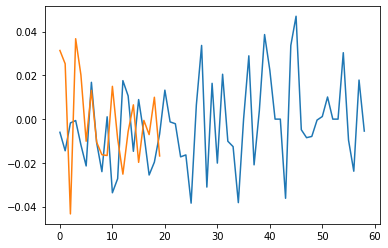

In [94]:
plt.plot(np.array(r_data)[:,1])
plt.plot(r_gauss[:,1])

In [95]:
r_gauss.shape

(20, 10)

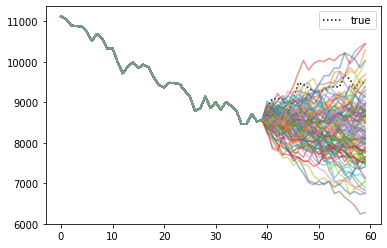

In [96]:
plt.plot(prix_a_split_train[indice][:,dim_aff],label='true',linestyle=':',color='black')
for n in range(N_sim):
    plt.plot(P[n,:,dim_aff],alpha=0.5)
plt.legend()
plt.savefig('result/gauss.pdf')

## Portfolio Optimization: Sharpe ratio maximization
1. Sous optimization classique: plusieur option pour le choix de la matice de covariance
    * cov des daily return de la fenetre (0,b)
    * cov des dily return de la fenetre (b,b+f) calculer a partir du scenario moyen generés
2. Une première solution est de garder une meme matrice de cov pour les 3 portfolio: traget, gan et markovitz. ca va permettre de comparer

In [97]:
w_boud=(0,1)
f_rebalance=f
f

20

### PAGAN optimization

In [98]:
def get_return_horizon(P):
    prix_last=P[w-1]
    prix_b=P[int(w-f-1)]
    return(prix_last/prix_b -1)


#get eprected return and all the price simulation
#example de data_b: L_b
#exemple e data_n: L_n
#exemple de data_r (data_reel): price_a_split_train
def get_predicted_return(N_sim,k_day,data_b,data_n,data_r):

    #data=L_b[k_day]
    data=data_b[k_day]
    data_test=data.reshape(1,data.shape[0],data.shape[1])
    noise_test=np.random.uniform(low=-1.0,high=1.0, size=(N_sim,1,2*k))

    S=np.zeros((N_sim,w,k))
    for i in range(N_sim):
        noise_t=noise_test[i].reshape(1,1,2*N_actif)
        ret_gene=generator.predict([data_test,noise_t])
        ret_gene_f=ret_gene.reshape(f,N_actif)

        data_fake=np.vstack((data,ret_gene_f))
        p_ini=data_n[k_day][0]
        df_fake=denomalize(p_ini,data_fake)
        
        S[i]=df_fake
    S_moy=np.mean(S,axis=0)
    mu=get_return_horizon(S_moy)
    #mu_daily=get_return(pd.DataFrame(S_moy[b:w]))
    #sig=mu_daily.cov()
    
    #pour l'instant, on prend matrice de covariance historique sur la fenetre visible
    sig=pd.DataFrame(data_r[k_day][:b]).cov()
    #moyenne sur les scenario generé et la moyenne historique
    return(mu,sig,S)

def get_optimal_weight(mu,cov_sig):
    ef = EfficientFrontier(mu, cov_sig,weight_bounds=w_boud)
    raw_weights =ef.max_sharpe()
    cleaned_weights = ef.clean_weights()
    w_optimal=np.array(list(chain(cleaned_weights.values())))
    return(w_optimal)



In [109]:
#freq: frequence de rebalancement
#portfolio value/return. multiply optimal weigth with true assets returns
def get_strat_value(N_sim,data_b,data_n,data_r,freq):
    N_days=len(data_b)
    W_f=[]
    R_f=[]
    for k_day in range(0,N_days):
        if k_day%freq==0:
            mu_k,sig_k,S=get_predicted_return(N_sim,k_day,data_b,data_n,data_r)
        w_opt=get_optimal_weight(mu_k,sig_k)
        W_f.append(w_opt)
        R_f.append(mu_k)
    W_f=np.array(W_f)
    R_f=np.array(R_f)
    #compute portfolio value
    r_true=np.array(get_return(pd.DataFrame(prix_a)))
    l_max=len(r_true)
    r_true_period=r_true[l_max-N_days:l_max]
    value_pf=np.sum(W_f*r_true_period,axis=1)
    return(W_f,R_f,value_pf)


W_f,R_f,v=get_strat_value(200,L_b_test,L_n_test,prix_a_split_test,f_rebalance) 
W_f.shape
v.shape

(1187,)

In [100]:
R_f.shape
W_f_df=pd.DataFrame(W_f)
W_f_df.head(100)

,0,1,2,3,4,5,6,7,8,9
0,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
2,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
3,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
4,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
5,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
6,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
7,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
8,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
9,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1


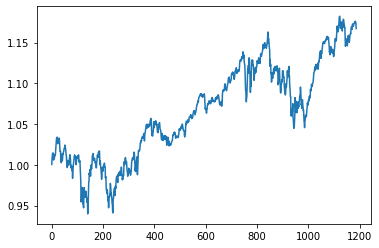

In [110]:
def cumreturn(ret):
    return((1+ret).cumprod())

value_gan=cumreturn(v)
plt.plot(value_gan)

### Markovitz PF optimization

4870


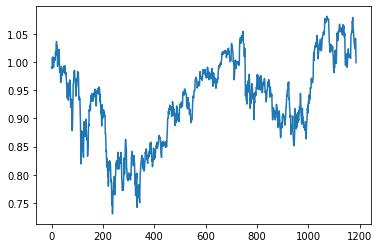

In [111]:
#get expected return and cov matrix a chaque data de rebalancement
def split_Markovitz(prix_a_data,freq):
    R=[]
    C=[]
    N_days=len(prix_a_data)
    for k in range(0,N_days,freq):
            data=pd.DataFrame(prix_a_data[k][:b]) #a modifier si pf voit dans le futur
            r_data=get_return(data) 
            mu_data=mean_historical_return(data)/252 # divide by 252 beacause of the original function of pypfopt
            #sig_data=CovarianceShrinkage(data).ledoit_wolf()
            
            #pour l'instant matrice de cov historique
            sig_data=r_data.cov()
            R.append(mu_data)
            C.append(sig_data)
    return(R,C)

def get_markov_weight(prix_a_data,R,C,freq):
    N_days=len(prix_a_data)
    W_markov=np.zeros((N_days,k))
    R_markov=[]
    for j in range(0,N_days):
        if j%freq==0:
            mu_expected,sig_expected=R[j//freq],C[j//freq]
        w_optimal_markov=get_optimal_weight(mu_expected,sig_expected)
        W_markov[j]=w_optimal_markov
        R_markov.append(np.array(mu_expected))

    #compute porfolio value avec prix_a
    r_true=np.array(get_return(pd.DataFrame(prix_a)))
    l_max=len(r_true)
    print(l_max)
    r_true_period=r_true[l_max-N_days:l_max]
    value_pf=np.sum(W_markov*r_true_period,axis=1)
    
    return(W_markov,R_markov,value_pf)



R,C=split_Markovitz(prix_a_split_test,f_rebalance)
W_markov,R_markov,v_markov=get_markov_weight(prix_a_split_test,R,C,f_rebalance)

value_markov=cumreturn(v_markov)
plt.plot(value_markov)

R_m=np.array(R_markov)

In [60]:
W_m_df=pd.DataFrame(W_markov)
W_m_df.head(100)

,0,1,2,3,4,5,6,7,8,9
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Target PF

4870


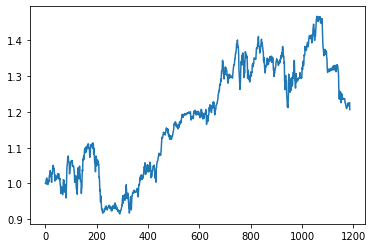

In [112]:
#get expected return and cov matrix a chaque data de rebalancement pour le portefeuille ideal
def split_pf_target(prix_a_data,freq):
    R=[]
    C=[]
    N_days=len(prix_a_data)
    for k in range(0,N_days,freq):
        data=pd.DataFrame(prix_a_data[k])
        r_data=get_return(data)
        #mu_data=r_data.iloc[-1]
        mu_data=get_return_horizon(prix_a_data[k])
        sig_data=r_data.cov()
        R.append(mu_data)
        C.append(sig_data)
    return(R,C)
        
R_target,C_target=split_pf_target(prix_a_split_test,f_rebalance)
W_target,R_target,v_target=get_markov_weight(prix_a_split_test,R_target,C_target,f_rebalance)

value_target=cumreturn(v_target)
plt.plot(value_target)

R_t=np.array(R_target)

## Mobile Average PF

4870


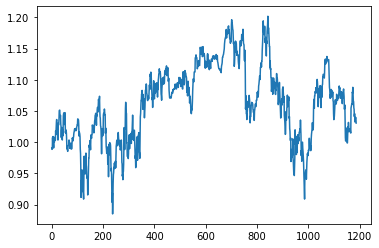

In [104]:
def split_pf_avg(prix_a_data,freq,list_avg):
    R=[]
    C=[]
    N_days=len(prix_a_data)
    for k in range(0,N_days,freq):
        prix_moy=list_avg[k]
        prix_true=prix_a_data[k]
        mu_data=prix_moy/prix_true[b]-1
        
        r_data=get_return(pd.DataFrame(prix_true))
        sig_data=r_data.cov()
        R.append(mu_data)
        C.append(sig_data)
    return(R,C)

R_avg,C_avg=split_pf_avg(prix_a_split_test,f_rebalance,list_avg_test)
W_avg,R_avg,v_avg=get_markov_weight(prix_a_split_test,R_avg,C_avg,f_rebalance)

value_avg=cumreturn(v_avg)
plt.plot(value_avg)


## Gaussian PF

4870


(1187,)

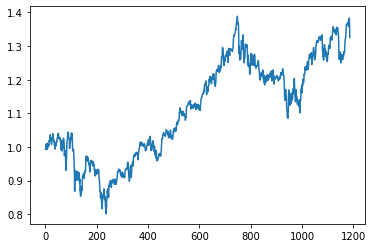

In [113]:
def split_pf_gauss(N_sim,prix_a_data,freq):
    R=[]
    C=[]
    N_days=len(prix_a_data)
    for k in range(0,N_days,freq):
        data=np.array(pd.DataFrame(prix_a_data[k]))
        P_gauss,prix_gauss,r_data,r_gauss=gaussian_simulate(N_sim,data)
        P_moy=np.mean(P_gauss,axis=0)
        mu_data=get_return_horizon(P_moy)
        
        r_moy=get_return(pd.DataFrame(P_moy))
        sig_data=r_moy.cov()
        
        R.append(mu_data)
        C.append(sig_data)
    return(R,C)

R_g,C_g=split_pf_gauss(300,prix_a_split_test,f_rebalance)
W_g,R_g,v_g=get_markov_weight(prix_a_split_test,R_g,C_g,f_rebalance)

value_g=cumreturn(v_g)
plt.plot(value_g)
v_g.shape

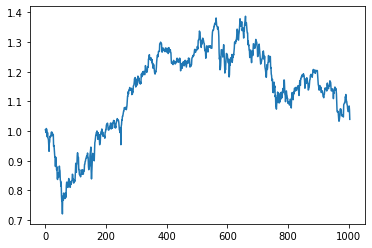

In [114]:
v_rbm=pd.read_csv('v_CRBM_pf1')
v_rbm_a=np.array(v_rbm)
v_rbm_a_c=v_rbm_a[:,1]
v_rbm_a_c.shape
value_rbm=cumreturn(v_rbm_a_c)
plt.plot(value_rbm)

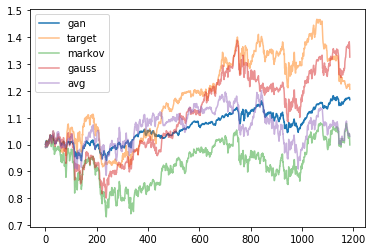

In [115]:


plt.plot(value_gan,label='gan')
plt.plot(value_target,label='target',alpha=0.5)
plt.plot(value_markov,label='markov',alpha=0.5)
plt.plot(value_g,label='gauss',alpha=0.5)
plt.plot(value_avg,label='avg',alpha=0.5)
#plt.plot(value_rbm,label='rbm')

plt.legend()
plt.savefig('result/pf_new.pdf')


### Comparaison des expected returns


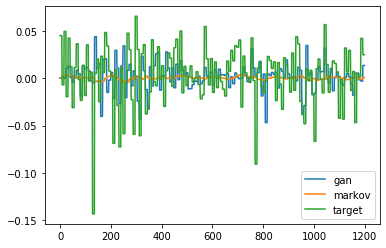

In [69]:
indice=4
plt.plot(R_f[:,indice],label='gan')
plt.plot(R_m[:,indice],label='markov')
plt.plot(R_t[:,indice],label='target')
plt.legend()

array([[1.        , 0.35706619],
       [0.35706619, 1.        ]])

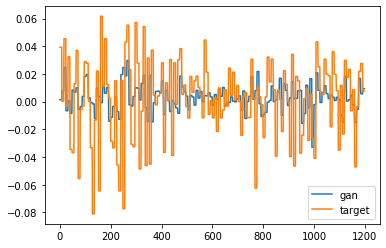

In [70]:
indice=0
plt.plot(R_f[:,indice],label='gan')
plt.plot(R_t[:,indice],label='target')
plt.legend()
np.corrcoef(R_f[:,indice], R_t[:,indice])

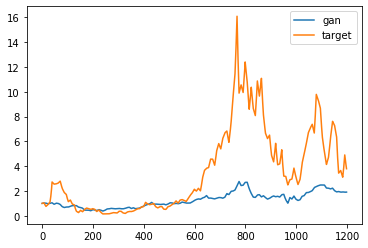

In [75]:
indice=1
plt.plot(cumreturn(R_f[:,indice]),label='gan')
plt.plot(cumreturn(R_t[:,indice]),label='target')
plt.legend()

## PF opti: return maximization with fix vol

In [65]:
def get_optimal_weight_fix_vol(mu,cov_sig):
    ef = EfficientFrontier(mu, cov_sig)
    raw_weights =ef.efficient_risk(0.05)
    cleaned_weights = ef.clean_weights()
    w_optimal=np.array(list(chain(cleaned_weights.values())))
    return(w_optimal)

def get_markov_weight_vol(R,C):
    N_days=len(R)
    W_markov=np.zeros((N_days,k))
    for j in range(N_days):
        mu_expected,sig_expected=R[j],C[j]
        w_optimal_markov=get_optimal_weight_fix_vol(mu_expected,sig_expected)
        W_markov[j]=w_optimal_markov
    return(W_markov)

W_markov_vol=get_markov_weight_vol(R,C)
value_markov_vol=value_from_weight(W_markov_vol,r_true)




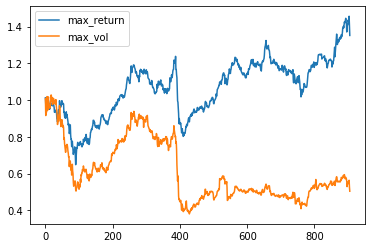

In [71]:
plt.plot(value_markov_vol,label='max_return')
plt.plot(value_markov,label='max_vol')
plt.legend()
plt.savefig('result/vol_var.pdf')

https://pyportfolioopt.readthedocs.io/en/latest/UserGuide.html

https://github.com/robertmartin8/PyPortfolioOpt/blob/master/docs/UserGuide.rst

courses: https://link.springer.com/article/10.1007/s11047-018-9685-y

In [285]:
sigma = np.sqrt(np.dot(w, np.dot(sig, w.T)))
sigma/np.sqrt(252)
11.38/np.sqrt(252)
0.422/np.sqrt(20)


0.09436206865049111

In [80]:
prix_a

array([[ 13.55172157,  32.75      ,   1.04300165,  40.48659897,
         23.25      ,  56.52893066],
       [ 13.64006615,  32.5       ,   1.08058715,  40.59527206,
         23.6875    ,  56.22878265],
       [ 13.3927021 ,  31.5       ,   1.11817288,  39.24468613,
         24.5       ,  53.8275528 ],
       ...,
       [ 69.75621796, 315.67001343,  46.66514206, 225.13999939,
         17.48999977,  13.94563389],
       [ 70.21052551, 318.17001343,  46.42705154, 223.13000488,
         17.81999969,  13.92611599],
       [ 71.43519592, 325.04000854,  46.19888687, 226.24000549,
         18.45999908,  14.11153698]])

# Remarque:
1. discriminator: 3 outputs: valid, fake,
2. la fonction diff fait bien: p(t)-p(t-1)

algo_genetique: https://github.com/msu-coinlab/pymoo/blob/master/pymoo/usage/problems/define_custom_problem.py

https://github.com/msu-coinlab/pymoo

# Keras
1. .compile: peremt de configurer le process d'apprentissage du model: à utilise avec model.complie(..): uniquement utiliser pour le train
2. .fit alternative au .train_on_batch plus rapide: uniquement utiliser pour le train. Ces deux fonctions prennent en argment les data en inputs X et les target date y (labels)
3. .predict: permet d'avoir l'output d'un model: prend en argument des vrais data.
4. .evaluate: permet de rentrer les data test: renvoie l'erreur, la loss ou autre element spécifié dans le .compile

# Algo génétiques

doc: https://pymoo.org/

quick start: https://pymoo.org/getting_started.html

In [410]:
import autograd.numpy as anp
from pymoo.util.misc import stack
from pymoo.model.problem import Problem

from pymoo.algorithms.nsga2 import NSGA2
from pymoo.factory import get_sampling, get_crossover, get_mutation

from pymoo.factory import get_termination

from pymoo.optimize import minimize
from pymoo.util import plotting

from pymoo.visualization.scatter import Scatter

In [411]:
#creation des inputs
print(len(L_b))
m,s,S=get_predicted_return(2,200,L_b_train,L_n_train,prix_a_split_train)
m.shape
S.shape

4128


(2, 48, 6)

In [412]:
def get_return_horizon_new(P):
    prix_last=P[:,w-1,:]
    prix_b=P[:,int(w-f-1),:]
    return(prix_last/prix_b -1)

#input prix pour N_simulation sur la fenetre de temps b,b+f
#return 2 array (esperance, variances) pour chacun de 6 actifs
def get_utile_horizon_from_simul(S):
    R_p=get_return_horizon_new(S)
    esp_R_p=np.mean(R_p,axis=0)
    var_R_p=np.var(R_p,axis=0)
    return(esp_R_p,var_R_p)


esp_R_p,var_R_p=get_utile_horizon_from_simul(S)

In [443]:
#m et esp_R_p: meme chose: ok 
print(m)
print(esp_R_p)

[-0.01689833  0.01163462  0.00043614  0.03054784 -0.06223185  0.00034382]
[-0.01689833  0.01163462  0.00043614  0.03054784 -0.06223185  0.00034382]


In [444]:
N_actif=6
class MyProblem(Problem):

    def __init__(self,esp_R_p,var_R_p):
        super().__init__(n_var=6,
                         n_obj=2,
                         n_constr=2,
                         xl=anp.array([0 for i in range(N_actif)]),
                         xu=anp.array([1 for i in range(N_actif)]))
        self.esp_R_p=esp_R_p
        self.var_R_p=var_R_p
    
    

    def _evaluate(self, x, out, *args, **kwargs):
        f1,f2=0,0
        for j in range(N_actif):
            f1+=-(x[:,j]*esp_R_p[j])
            f2+=x[:,j]*var_R_p[j]
            
        g1,g2=0,0
        for j in range(N_actif):
            g1+=x[:, j]
            g2+=x[:, j]
        g1+=-1
        g2=0.999-g2
        
        out["F"] = anp.column_stack([f1, f2])
        out["G"] = anp.column_stack([g1,g2])
        
    def _calc_pareto_front(self, flatten=True, **kwargs):
        f1_a = np.linspace(0.1**2, 0.4**2, 100)
        f2_a = (np.sqrt(f1_a) - 1)**2

        f1_b = np.linspace(0.6**2, 0.9**2, 100)
        f2_b = (np.sqrt(f1_b) - 1)**2

        a, b = np.column_stack([f1_a, f2_a]), np.column_stack([f1_b, f2_b])
        return stack(a, b, flatten=flatten)

    # --------------------------------------------------
    # Pareto-set - not necessary but used for plotting
    # --------------------------------------------------
    def _calc_pareto_set(self, flatten=True, **kwargs):
        x1_a = np.linspace(0.1, 0.4, 50)
        x1_b = np.linspace(0.6, 0.9, 50)
        x2 = np.zeros(50)

        a, b = np.column_stack([x1_a, x2]), np.column_stack([x1_b, x2])
        return stack(a,b, flatten=flatten)
    
problem = MyProblem(esp_R_p,var_R_p)


In [445]:
algorithm = NSGA2(
    pop_size=50,
    n_offsprings=20,
    sampling=get_sampling("real_random"),
    crossover=get_crossover("real_sbx", prob=0.9, eta=15),
    mutation=get_mutation("real_pm", eta=20),
    eliminate_duplicates=True
)

In [446]:
termination = get_termination("n_gen", 300)

In [447]:
res = minimize(problem,
               algorithm,
               termination,
               seed=1,
               pf=problem.pareto_front(use_cache=False),
               save_history=True,
               verbose=True)

n_gen | n_eval  | cv (min/avg)                | igd          | gd           | hv          
1     | 50      | 0.5931811769 / 2.0508559379 | -            | -            | -           
2     | 70      | 0.4301593184 / 1.5909522629 | -            | -            | -           
3     | 90      | 0.4301593184 / 1.2700537723 | -            | -            | -           
4     | 110     | 0.2259255514 / 1.0383207190 | -            | -            | -           
5     | 130     | 0.0167013701 / 0.8421177070 | -            | -            | -           
6     | 150     | 0.0167013701 / 0.6150857572 | -            | -            | -           
7     | 170     | 0.0167013701 / 0.4148564971 | -            | -            | -           
8     | 190     | 0.0167013701 / 0.3008215293 | -            | -            | -           
9     | 210     | 0.0034825366 / 0.2039951928 | -            | -            | -           
10    | 230     | 0.0034825366 / 0.1397048898 | -            | -            | -           

100   | 2030    | 0.0000000000 / 0.0000000000 | 0.5615009624 | 0.3912234400 | 0.6543882865
101   | 2050    | 0.0000000000 / 0.0000000000 | 0.5615009624 | 0.3912277236 | 0.6543882865
102   | 2070    | 0.0000000000 / 0.0000000000 | 0.5615009624 | 0.3912277236 | 0.6543882865
103   | 2090    | 0.0000000000 / 0.0000000000 | 0.5615010924 | 0.3912278232 | 0.6543882865
104   | 2110    | 0.0000000000 / 0.0000000000 | 0.5615010924 | 0.3912318803 | 0.6543882872
105   | 2130    | 0.0000000000 / 0.0000000000 | 0.5615010924 | 0.3912318803 | 0.6543882872
106   | 2150    | 0.0000000000 / 0.0000000000 | 0.5615010924 | 0.3912360631 | 0.6543882872
107   | 2170    | 0.0000000000 / 0.0000000000 | 0.5615011336 | 0.3912407750 | 0.6543884665
108   | 2190    | 0.0000000000 / 0.0000000000 | 0.5615011336 | 0.3912414415 | 0.6543884665
109   | 2210    | 0.0000000000 / 0.0000000000 | 0.5615011336 | 0.3912428622 | 0.6543884665
110   | 2230    | 0.0000000000 / 0.0000000000 | 0.5615011336 | 0.3912520214 | 0.6543884665

208   | 4190    | 0.0000000000 / 0.0000000000 | 0.5593807414 | 0.3906355670 | 0.6544912286
209   | 4210    | 0.0000000000 / 0.0000000000 | 0.5593807414 | 0.3906355670 | 0.6544912286
210   | 4230    | 0.0000000000 / 0.0000000000 | 0.5593807414 | 0.3906504573 | 0.6544912286
211   | 4250    | 0.0000000000 / 0.0000000000 | 0.5593807414 | 0.3906701560 | 0.6544912286
212   | 4270    | 0.0000000000 / 0.0000000000 | 0.5593807414 | 0.3906701560 | 0.6544912286
213   | 4290    | 0.0000000000 / 0.0000000000 | 0.5593807414 | 0.3906708341 | 0.6544912286
214   | 4310    | 0.0000000000 / 0.0000000000 | 0.5593807414 | 0.3906708341 | 0.6544912286
215   | 4330    | 0.0000000000 / 0.0000000000 | 0.5593807414 | 0.3906708341 | 0.6544912286
216   | 4350    | 0.0000000000 / 0.0000000000 | 0.5593807414 | 0.3906708341 | 0.6544912286
217   | 4370    | 0.0000000000 / 0.0000000000 | 0.5593807414 | 0.3906865332 | 0.6544912637
218   | 4390    | 0.0000000000 / 0.0000000000 | 0.5593807414 | 0.3907057419 | 0.6544926126

In [448]:
#verif 
n_sol=3
print(res.X.shape)
x_op1=res.X[n_sol,:]
print(np.sum(x_op1*esp_R_p))
print(np.sum(x_op1*var_R_p))
print(res.F[n_sol,:])

(35, 6)
-0.0023093493915089854
0.0008448604503429125
[0.00230935 0.00084486]


(35, 2)


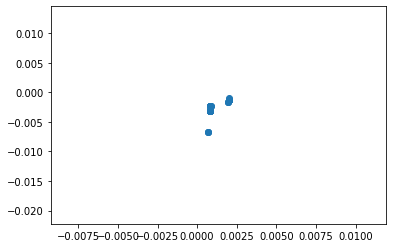

In [449]:
print(res.F.shape)
plt.scatter(res.F[:,1],-res.F[:,0])

In [419]:
Z=25
chi_list=[i for i in range(1,Z+1)]



In [420]:
def get_r_chi(chi,r_max):
    r_Z=2*r_max-1
    r_1=1
    return(r_1+((chi-1)*(r_Z-r_1))/(Z-1))

R_true=np.array(get_return(pd.DataFrame(prix_a)))
R_max=np.max(np.max(R_true,axis=0))
R_max.shape
R_max

0.18604659065498708

In [421]:
R_chi=get_r_chi(10,R_max)

In [422]:
R_chi

0.38953494299124036

In [427]:
res.F

array([[0.00157445, 0.00197139],
       [0.00312642, 0.00081383],
       [0.00121315, 0.0019915 ],
       [0.00230935, 0.00084486],
       [0.00121148, 0.00199163],
       [0.00121138, 0.00199164],
       [0.00235567, 0.00083958],
       [0.00121324, 0.00199149],
       [0.00312643, 0.00081383],
       [0.00230931, 0.00084486],
       [0.00157438, 0.00197139],
       [0.00675599, 0.00070397],
       [0.00312866, 0.00081366],
       [0.00157446, 0.00197139],
       [0.00312634, 0.00081388],
       [0.00092367, 0.00199201],
       [0.00234302, 0.00083959],
       [0.00233679, 0.00083975],
       [0.0023372 , 0.00083973],
       [0.00234266, 0.00083961],
       [0.00234242, 0.00083962],
       [0.00233618, 0.00084025],
       [0.00676138, 0.00070361],
       [0.00121146, 0.00199163],
       [0.0067615 , 0.0007036 ],
       [0.0012113 , 0.00199164],
       [0.00121323, 0.00199149],
       [0.00313119, 0.00081166],
       [0.00312871, 0.00081366],
       [0.0031269 , 0.00081382],
       [0.

In [436]:
R_scenario=-res.F[:,0]

#input: resultat de la simulation
#return: rendement et poids associé du pf pour une jour donnée
def get_scenario(esp_R_p,var_R_p):
    problem = MyProblem(esp_R_p,var_R_p)
    algorithm = NSGA2(pop_size=50,
            n_offsprings=20,
            sampling=get_sampling("real_random"),
            crossover=get_crossover("real_sbx", prob=0.9, eta=15),
            mutation=get_mutation("real_pm", eta=20),
            eliminate_duplicates=True)
    termination = get_termination("n_gen", 300)
    res = minimize(problem,
               algorithm,
               termination,
               seed=1,
               pf=problem.pareto_front(use_cache=False),
               save_history=True,
               verbose=False)
    return(res.F,res.X)

#selection du sceanrio optimal pour un jour donnée
def get_weight_strat(R_scenario,chi,W_scenario):
    R_chi=get_r_chi(chi,R_max)
    R_obj=np.abs(R_chi-R_scenario)
    index_opt=np.argmin(R_obj)
    print('index',index_opt)
    return(W_scenario[index_opt,:],R_scenario[index_opt])

get_weight_strat(R_scenario,20,res.X)        

index 24


(array([0.00277893, 0.09046658, 0.23453462, 0.29888139, 0.27371047,
        0.09875791]), -0.006761497571575605)

In [409]:
#return succesive optimal weight during the trading period
def get_weight_over_period(N_sim,freq,chi):
    N_days=len(L_b)
    N_rebalance=int(N_days/freq)
    print(N_rebalance)
    W_f=[]
    R_f=[]
    for k_day in range(0,N_days,freq):
        print(k_day)
        _,_,S_k=get_predicted_return(N_sim,k_day)
        esp_R_p,var_R_p=get_utile_horizon_from_simul(S_k)
        R_scenario,W_scenario=get_scenario(esp_R_p,var_R_p)
        R_scenario=R_scenario[:,0]
        W_f.append(get_weight_strat(R_scenario,chi,W_scenario)[0])
        R_f.append(get_weight_strat(R_scenario,chi,W_scenario)[1])
    W_f=np.array(W_f)
    R_f=np.array(R_f)

    return(W_f,R_f)
        
        
get_weight_over_period(2,f,2)        
        
    
    
    

226
0
(43,)
index_op 40
ok
(43,)
(43,)
index_op 40
ok
(43,)
20
(43,)
index_op 40
ok
(43,)
(43,)
index_op 40
ok
(43,)
40
(43,)
index_op 40
ok
(43,)
(43,)
index_op 40
ok
(43,)
60
(43,)
index_op 40
ok
(43,)
(43,)
index_op 40
ok
(43,)
80
(43,)
index_op 40
ok
(43,)
(43,)
index_op 40
ok
(43,)
100
(43,)
index_op 40
ok
(43,)
(43,)
index_op 40
ok
(43,)
120
(43,)
index_op 40
ok
(43,)
(43,)
index_op 40
ok
(43,)
140
(43,)
index_op 40
ok
(43,)
(43,)
index_op 40
ok
(43,)
160
(43,)
index_op 40
ok
(43,)
(43,)
index_op 40
ok
(43,)
180
(43,)
index_op 40
ok
(43,)
(43,)
index_op 40
ok
(43,)
200
(43,)
index_op 40
ok
(43,)
(43,)
index_op 40
ok
(43,)
220
(43,)
index_op 40
ok
(43,)
(43,)
index_op 40
ok
(43,)
240
(43,)
index_op 40
ok
(43,)
(43,)
index_op 40
ok
(43,)
260
(43,)
index_op 40
ok
(43,)
(43,)
index_op 40
ok
(43,)
280
(43,)
index_op 40
ok
(43,)
(43,)
index_op 40
ok
(43,)
300
(43,)
index_op 40
ok
(43,)
(43,)
index_op 40
ok
(43,)
320
(43,)
index_op 40
ok
(43,)
(43,)
index_op 40
ok
(43,)
340
(43,)
index_

KeyboardInterrupt: 

## Prediction return several days forward

In [221]:
def build_predictor():
    model_c = Sequential()
    model_c.add(Conv1D(k, kernel_length, strides=2, activation='relu', input_shape=(b, k),padding='same'))
    model_c.add(Conv1D(k, kernel_length, strides=2, activation='relu',padding='same'))
    model_c.add(Conv1D(k, kernel_length, strides=2, activation='relu',padding='same'))
    model_c.add(Conv1D(k, kernel_length, strides=2, activation='relu',padding='same'))
    model_c.add(Flatten())
    model_c.add(Dense(k, activation='relu'))
    model_c.add(Reshape((1,k)))
    print(model_c.summary())
    
    M_b_tensor=Input(shape=(b,k),name='M_b_real')
    output_conv = model_c(M_b_tensor)
    
    #simulator
    model_s = Sequential()
    model_s.add(Dense(f*k, activation='relu',input_shape=(1*k,)))
    model_s.add(Reshape((int(f/4), int(4*k))))
    model_s.add(Reshape(( -1, int(f/4),int(4*k))))
    model_s.add(Conv2DTranspose(int(2*k),kernel_size=(1,5),strides=(1,2),padding='same'))
    model_s.add(Conv2DTranspose(int(k),kernel_size=(1,5),strides=(1,2),padding='same'))
    model_s.add(Reshape((int(f), int(k))))
    model_s.summary()
    
    output_final_gene=model_s(output_conv)
    
    
    
    return(Model(M_b_tensor, output_final_gene))

    

In [240]:
optimizer = Adam(lr=0.0005,beta_1=0.5)
predictor=build_predictor()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_35 (Conv1D)           (None, 20, 6)             186       
_________________________________________________________________
conv1d_36 (Conv1D)           (None, 10, 6)             186       
_________________________________________________________________
conv1d_37 (Conv1D)           (None, 5, 6)              186       
_________________________________________________________________
conv1d_38 (Conv1D)           (None, 3, 6)              186       
_________________________________________________________________
flatten_9 (Flatten)          (None, 18)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 6)                 114       
_________________________________________________________________
reshape_25 (Reshape)         (None, 1, 6)              0         
Total para

In [241]:
M_b_real = Input(shape=(b,k),name='M_b_t')
M_f_tilde=predictor(M_b_real)
predictor_model=Model(inputs=M_b_real,outputs=M_f_tilde)
predictor_model.compile(loss='mean_squared_error',optimizer=optimizer)

In [242]:
w_roll=1
scaler_3=MinMaxScaler(feature_range=(0, 1))

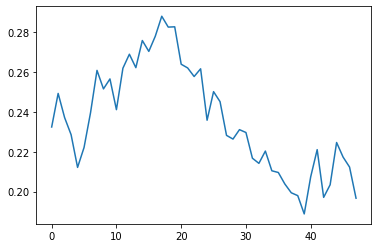

In [243]:
prix_a_n=scaler_3.fit_transform(prix_a)
prix_split=split_simple(prix_a_n,48,w_roll)
#plt.plot(prix_a_n[:,1])
plt.plot(prix_split[0][:,1])

In [244]:
data=np.array(prix_split)
data_target=data[:,b:b+f,:]
data_input=data[:,:b,:]

D_target_train=data_target[:N_train]
D_input_train=data_input[:N_train]

D_target_test=data_target[N_train:]
D_input_test=data_input[N_train:]
    


In [245]:
hist = predictor_model.fit(D_input_train, D_target_train, batch_size=batch_size, nb_epoch=100, 
verbose=2, validation_data=(D_input_test, D_target_test))

C:\Users\rochej\AppData\Local\Continuum\anaconda3\envs\ml_env\lib\site-packages\ipykernel_launcher.py:2: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 3624 samples, validate on 504 samples
Epoch 1/100
 - 2s - loss: 0.2038 - val_loss: 0.5456
Epoch 2/100
 - 0s - loss: 0.0785 - val_loss: 0.1326
Epoch 3/100
 - 0s - loss: 0.0231 - val_loss: 0.0959
Epoch 4/100
 - 0s - loss: 0.0142 - val_loss: 0.0860
Epoch 5/100
 - 0s - loss: 0.0105 - val_loss: 0.0814
Epoch 6/100
 - 0s - loss: 0.0088 - val_loss: 0.0848
Epoch 7/100
 - 0s - loss: 0.0081 - val_loss: 0.0816
Epoch 8/100
 - 0s - loss: 0.0076 - val_loss: 0.0817
Epoch 9/100
 - 0s - loss: 0.0070 - val_loss: 0.0786
Epoch 10/100
 - 0s - loss: 0.0065 - val_loss: 0.0731
Epoch 11/100
 - 0s - loss: 0.0059 - val_loss: 0.0664
Epoch 12/100
 - 0s - loss: 0.0053 - val_loss: 0.0564
Epoch 13/100
 - 0s - loss: 0.0048 - val_loss: 0.0517
Epoch 14/100
 - 0s - loss: 0.0043 - val_loss: 0.0468
Epoch 15/100
 - 0s - loss: 0.0039 - val_loss: 0.0419
Epoch 16/100
 - 0s - loss: 0.0035 - val_loss: 0.0395
Epoch 17/100
 - 0s - loss: 0.0032 - val_loss: 0.0357
Epoch 18/100
 - 0s - loss: 0.0029 - val_loss: 0.0319
Epoch 19

(40, 6)
(1, 8, 6)


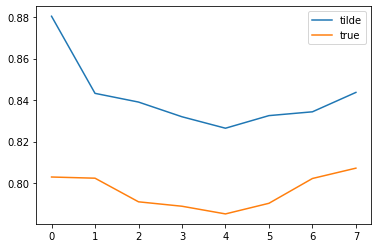

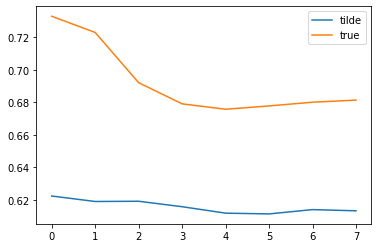

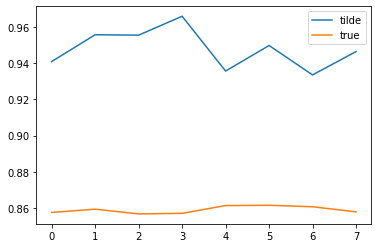

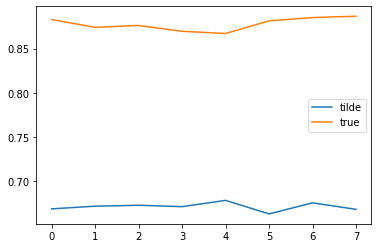

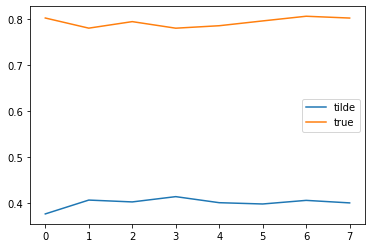

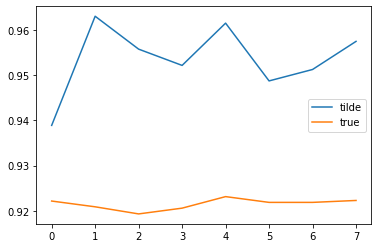

In [246]:
ind=300
d_test=D_input_test[ind]
d_test_r=d_test.reshape(1,b,N_actif)
print(d_test.shape)
prix_target=D_target_test[ind]
prix_tilde=predictor.predict(d_test_r)
print(prix_tilde.shape)

def aff():
    indice=1
    for indice in range(N_actif):
        plt.figure()
        prix_tilde.reshape(f,N_actif)
        plt.plot(prix_tilde.reshape(f,N_actif)[:,indice],label='tilde')
        plt.plot(prix_target[:,indice],label='true')
        plt.legend()
aff()


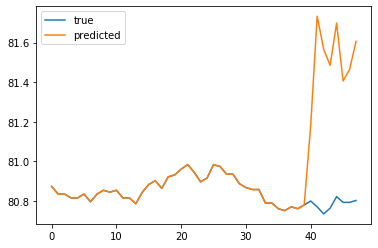

In [247]:
prix_tilde_dn=scaler_3.inverse_transform(prix_tilde.reshape(f,N_actif))
prix_target_dn=scaler_3.inverse_transform(prix_target)
prix_input_dn=scaler_3.inverse_transform(d_test_r.reshape(b,N_actif))

prix_true=np.vstack([prix_input_dn,prix_target_dn])
prix_predicted=np.vstack([prix_input_dn,prix_tilde_dn])

indice=5
plt.plot(prix_true[:,indice],label='true')
plt.plot(prix_predicted[:,indice],label='predicted')
plt.legend()

In [248]:
def get_predicted_return_forcast(k_day,data_b):
    data=data_b[k_day]
    data_test=data.reshape(1,data.shape[0],data.shape[1])

    prix_tilde=predictor.predict(data_test)
    prix_tilde=prix_tilde.reshape(f,N_actif)
    prix_fake=np.vstack((data,prix_tilde))
    prix_fake_dn=scaler_3.inverse_transform(prix_fake)

    mu=get_return_horizon(prix_fake_dn)
    #mu_daily=get_return(pd.DataFrame(S_moy[b:w]))
    #sig=mu_daily.cov()
    #pour l'instant, on prend matrice de covariance historique sur la fenetre visible
    sig=get_return(pd.DataFrame(prix_fake_dn[:b])).cov()
    #moyenne sur les scenario generé et la moyenne historique
    return(mu,sig)

m,s= get_predicted_return_forcast(3,D_input_test)
m

array([-0.0118006 , -0.04625413,  0.01597189, -0.11319607, -0.1810326 ,
       -0.00099792])

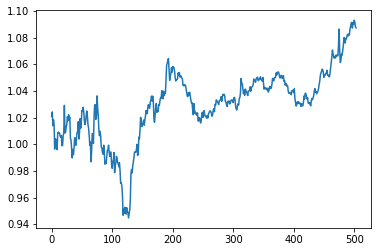

In [249]:
#freq: frequence de rebalancement
#portfolio value/return. multiply optimal weigth with true assets returns
def get_strat_value_forcast(data_b,freq):
    N_days=len(data_b)
    W_f=[]
    R_f=[]
    for k_day in range(0,N_days):
        if k_day%freq==0:
            mu_k,sig_k=get_predicted_return_forcast(k_day,data_b)
        w_opt=get_optimal_weight(mu_k,sig_k)
        W_f.append(w_opt)
        R_f.append(mu_k)
    W_f=np.array(W_f)
    R_f=np.array(R_f)
    #compute portfolio value
    r_true=np.array(get_return(pd.DataFrame(prix_a)))
    l_max=len(r_true)
    r_true_period=r_true[l_max-N_days:l_max]
    value_pf=np.sum(W_f*r_true_period,axis=1)
    return(W_f,R_f,value_pf)


W_for,R_for,v_for=get_strat_value_forcast(D_input_test,f_rebalance) 
#W_f.shape
#v.shape
value_for=cumreturn(v_for)
plt.plot(value_for)

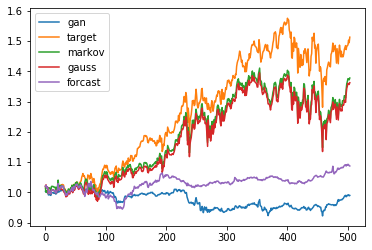

In [250]:
plt.plot(value_gan,label='gan')
plt.plot(value_target,label='target')
plt.plot(value_markov,label='markov')
plt.plot(value_g,label='gauss')
plt.plot(value_for,label='forcast')
plt.legend()

In [91]:
len(D_input_test)

504

## prediction simple (day to day) :MLP

In [116]:
def get_random_block_from_data(data, batch_size):
    start_index = np.random.randint(0, len(data) - batch_size)
    return data[start_index:(start_index + batch_size)]

In [117]:
scaler_2 = MinMaxScaler(feature_range=(0, 1))


In [118]:
window=500
#data=get_return(pd.DataFrame(prix_a))
data=pd.DataFrame(scaler_2.fit_transform(pd.DataFrame(prix_a)))
data.name='pf1'
shift_day=1
data_target=data.shift(-shift_day)
data_target=data_target.dropna()

data_input=data.iloc[:len(data)-shift_day]
data_input.name='input'
data_input.columns=[str(data_input.name)+': '+str(i) for i in range(N_actif)]
data_target.columns=['target'+': '+str(i) for i in range(N_actif)]

c_input=[c for c in data_input.columns]
c_target=[c for c in data_target.columns ]


D=pd.concat([data_input,data_target],axis=1)
D_train=D[:N_train]
D_test=D[N_train:]
data_cible=data_target[len(D)-window:]


In [119]:

D.head(3)
len(D)
len(D_train)
len(D_test)



1246

In [120]:
d=N_actif
tf_features=tf.placeholder(tf.float32,shape=[None,d])
tf_target= tf.placeholder(tf.float32,shape=[None,d])

dp=d

w1=tf.Variable(tf.random_normal([d,dp ]))
w2=tf.Variable(tf.random_normal([dp,d]))
b1=tf.Variable(tf.zeros(dp))
b2=tf.Variable(tf.zeros(d))

z1=tf.matmul(tf_features,w1)+b1
z1a=tf.nn.leaky_relu(z1,alpha=0.5,name=None)

z2=tf.matmul(z1a,w2)+b2
z2a=tf.nn.leaky_relu(z2,alpha=0.5,name=None)
output=z2a

'regularisation: contre overfitting'
alpha=0.00001
regularizer = tf.nn.l2_loss(w1) + tf.nn.l2_loss(w2)
'definition de lerreur MSE : moindre carré'
#erreur=tf.reduce_mean(tf.square(output-tf_features))
erreur=0.5*tf.reduce_mean(tf.square(output-tf_target))+0.5*alpha*regularizer

'minimisation de lerreur'
decay_step = tf.Variable(2, trainable=False)
starter_learning_rate=0.1
#    decay_step=1
global_step=tf.placeholder(tf.int32)
decay_rate=0.1
#    learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step, decay_step, decay_rate, staircase=True)
learning_rate = tf.train.inverse_time_decay(starter_learning_rate, global_step, decay_step, decay_rate, staircase=True)
#    learning_rate=0.0001
optimizer = tf.train.AdamOptimizer(learning_rate)
'opération dentrainement'
train = optimizer.minimize(erreur)

'parametre de batch'
batch_size = 100
n_samples=len(D)

'definition session: contient le graphe defini précédemment + initialisation'
sess=tf.Session()
sess.run(tf.global_variables_initializer())

E_train=[]
E_test=[]
ax=[]

epoch=100
for e in range(epoch + 1):
    avg_err = 0
    total_batch = int(n_samples / batch_size)
    for i in range(total_batch):
        batch = get_random_block_from_data(D_train, batch_size)
        batch_input=batch[c_input]
        batch_target=batch[c_target]        
        sess.run(train,feed_dict={tf_features:batch_input,tf_target:batch_target,global_step:e})
        
        err=sess.run(erreur,feed_dict={tf_features:batch_input,tf_target:batch_target})
        avg_err += err / n_samples * batch_size
        
    if (e%10==0):
        print(sess.run(learning_rate,feed_dict={tf_features:D_test[c_input],tf_target:D_test[c_target],global_step:e}))
        #ax.append(e)
        E_train.append(avg_err)
        E_test.append(sess.run(erreur,feed_dict={tf_features:D_test[c_input],tf_target:D_test[c_target]}))
        err_t=sess.run(erreur,feed_dict={tf_features:D_test[c_input],tf_target:D_test[c_target]})
        print(str(e) + ": erreur_train:" + str(avg_err) + " erreur_test: " + str(err_t) )
    #output: prix du lendemain si shift_day=1  
    sortie=sess.run(output,feed_dict={tf_features:D_test[c_input]})
    sortie=pd.DataFrame(sortie,columns=D_test[c_input].columns,index=D_test.index)
    A=pd.concat([sortie,D_test[c_target]],axis=1)
    

W1021 17:08:56.736302  7468 deprecation.py:323] From C:\Users\rochej\AppData\Local\Continuum\anaconda3\envs\ml_env\lib\site-packages\tensorflow\python\keras\optimizer_v2\learning_rate_schedule.py:520: div (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


0.1
0: erreur_train:0.1674317903969689 erreur_test: 0.4553858
0.06666667
10: erreur_train:0.0020243434268441937 erreur_test: 0.033499453
0.05
20: erreur_train:0.0008102114901837779 erreur_test: 0.022101222
0.04
30: erreur_train:0.0006528354636670779 erreur_test: 0.017365849
0.033333335
40: erreur_train:0.0004649190565626647 erreur_test: 0.008707119
0.028571429
50: erreur_train:0.00041890038044461525 erreur_test: 0.0057178074
0.025
60: erreur_train:0.0004075556051404859 erreur_test: 0.0050166897
0.022222223
70: erreur_train:0.0006575116119634369 erreur_test: 0.0044016903
0.02
80: erreur_train:0.00033322728353263743 erreur_test: 0.005296784
0.018181818
90: erreur_train:0.0003515681236584575 erreur_test: 0.0038701254
0.016666668
100: erreur_train:0.00034915408821397856 erreur_test: 0.004788005


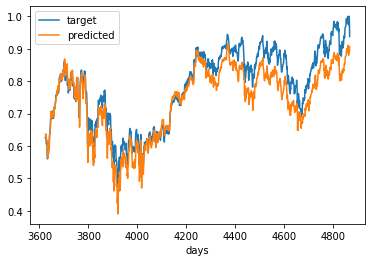

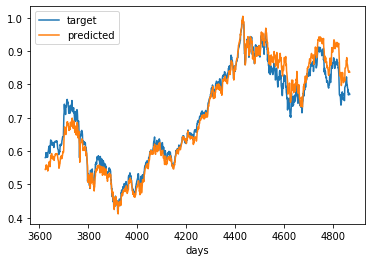

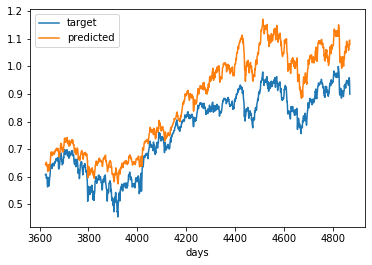

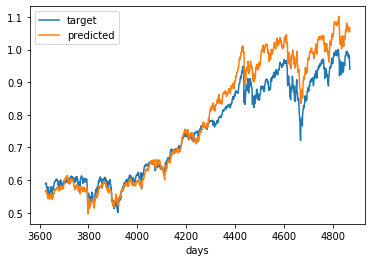

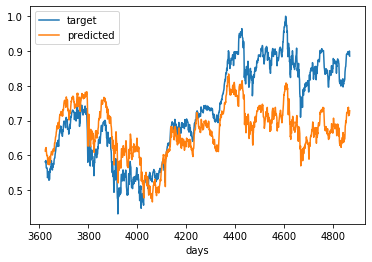

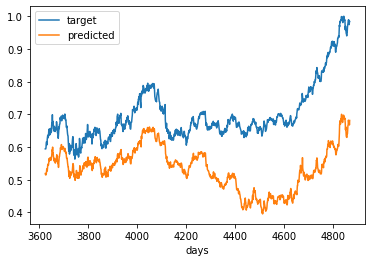

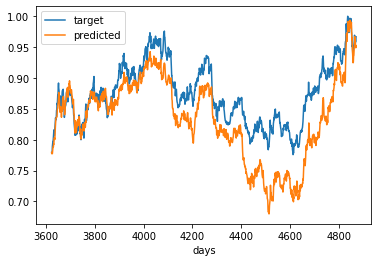

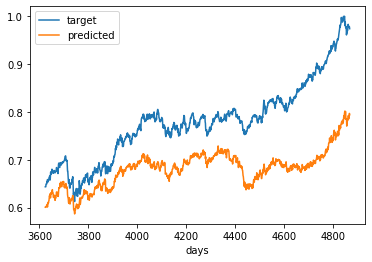

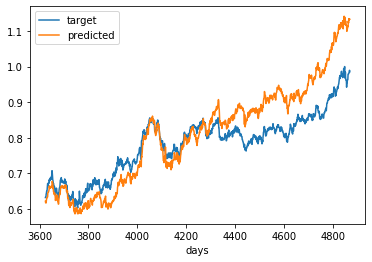

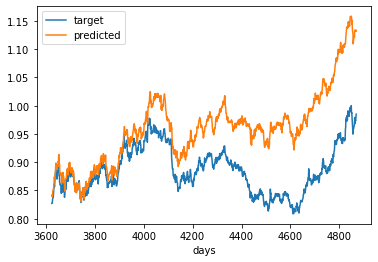

In [121]:
#sans reentrainement

for n in range(N_actif):
    plt.figure()
    plt.plot(A['target: '+str(n)],label='target')
    plt.plot(A['input: '+str(n)],label='predicted')
    plt.xlabel('days')
    plt.legend()
    plt.savefig('result/pred'+str(n)+'.pdf')

    

In [122]:
#reentrainement
n=len(D_test)
sortie_final=[]
for i in range(1,n):
    prix_new=D_test[c_input][:i]
    prix_new_target=D_test[c_target][:i]
    sess.run(train,feed_dict={tf_features:prix_new,tf_target:prix_new_target,global_step:e})
    s=sess.run(output,feed_dict={tf_features:prix_new})
    sortie_final.append(s[-1])
sortie_final=np.array(sortie_final)
#sortie_final=sess.run(output,feed_dict={tf_features:D_test[c_input]})

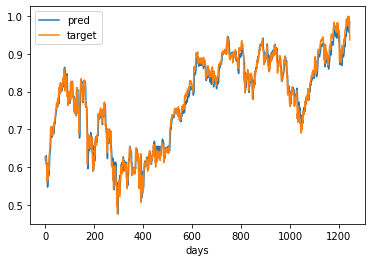

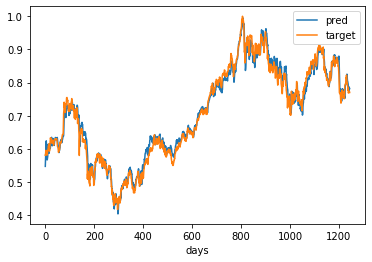

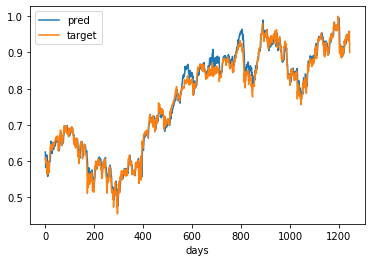

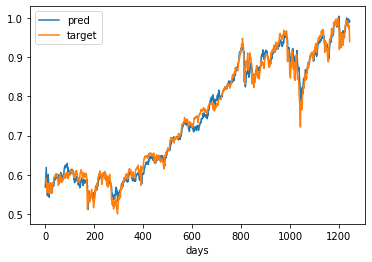

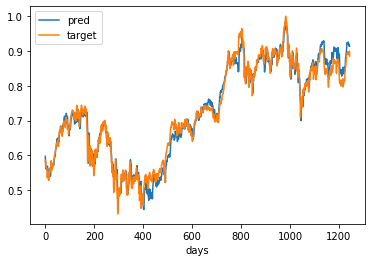

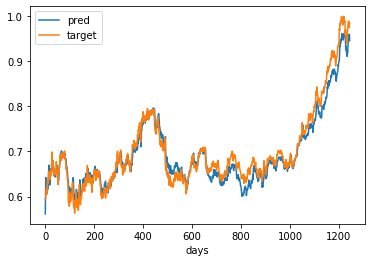

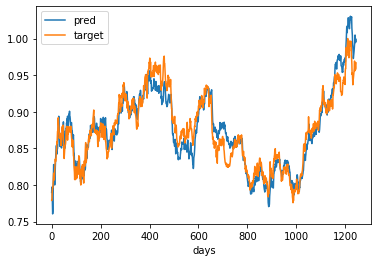

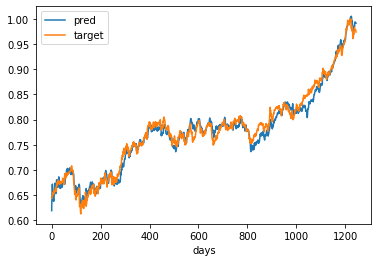

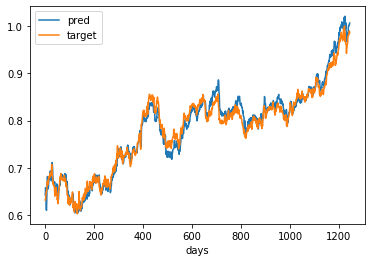

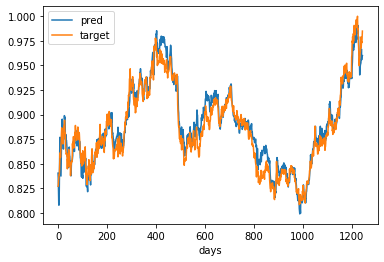

In [123]:
#avec reentrainement
sortie_final.shape
sortie_target=np.array(D_test[c_target])[1:]
for indice in range(N_actif):
    plt.figure()
    plt.plot(sortie_final[:,indice],label='pred')
    plt.plot(sortie_target[:,indice],label='target')
    plt.xlabel('days')
    plt.legend()
    plt.savefig('result/pred_RL'+str(indice)+'.pdf')
    

In [127]:
sortie_a=np.array(sortie_final)
#R,C=split_pf_target(sortie_a,f_rebalance)
#split de la data predicted generé
sortie_final_dn=scaler_2.inverse_transform(sortie_final)
sortie_split=split_simple(sortie_final_dn,w,w_roll)

sortie_split_true=split_simple(prix_a[prix_a.shape[0]-len(sortie_final):],w,w_roll)
len(sortie_split_true)
len(sortie_split)

1185

In [128]:
sortie_a.shape

(1245, 10)

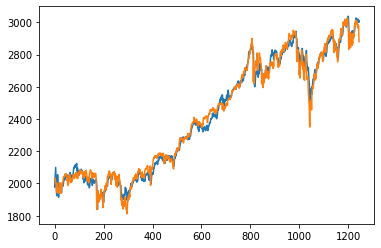

In [129]:
#denormalize et on checks
plt.plot(sortie_final_dn[:,3])
plt.plot(prix_a[prix_a.shape[0]-len(sortie_final):,3])

4870


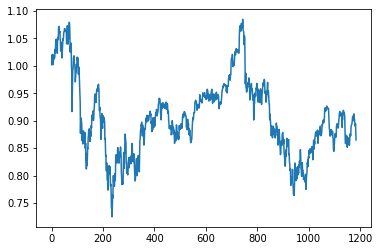

In [130]:
#input: list de matrice de prix forcated , mm chose pour les prix réeell
def get_return_forcast(prix_for, prix_true,freq):
    R=[]
    C=[]
    N_days=len(prix_for)
    for k in range(0,N_days,freq):
        data_for=prix_for[k]
        data_true=prix_true[k]
        r_data=get_return(pd.DataFrame(data_for))
        r_true=get_return(pd.DataFrame(data_true)).iloc[:b]
        r=pd.concat([r_true,r_data.iloc[b:]],axis=0)
        
        
        mu_data=r_data.iloc[-1]
        sig_data=r.cov()
        R.append(mu_data)
        C.append(sig_data)
    return(R,C)

R_for,C_for=get_return_forcast(sortie_split,sortie_split_true,f_rebalance)
W_for,Ret_for,v_for=get_markov_weight(sortie_split,R_for,C_for,f_rebalance)

value_for=cumreturn(v_for)
plt.plot(value_for)



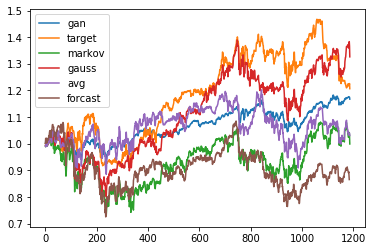

In [131]:
plt.plot(value_gan,label='gan')
plt.plot(value_target,label='target')
plt.plot(value_markov,label='markov')
plt.plot(value_g,label='gauss')
plt.plot(value_avg,label='avg')
plt.plot(value_for,label='forcast')
plt.legend()

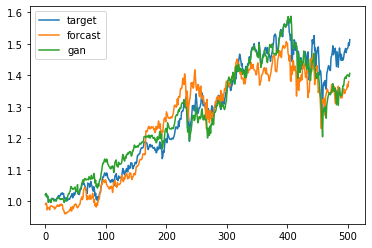

In [80]:
plt.plot(value_target,label='target')
plt.plot(value_for,label='forcast')
plt.plot(value_gan,label='gan')
plt.legend()

## Statistical analysis

In [90]:
def heatMap(df):
    #Create Correlation df
    corr = df.corr()
    #Plot figsize
    fig, ax = plt.subplots(figsize=(5, 5))
    #Generate Color Map
    colormap = sns.diverging_palette(220, 10, as_cmap=True)
    #Generate Heat Map, allow annotations and place floats in map
    sns.heatmap(corr, cmap=colormap, annot=True, fmt=".2f")
    #Apply xticks
    plt.xticks(range(len(corr.columns)), corr.columns);
    #Apply yticks
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.savefig('result/spatialtrue')
    #show plot
    #plt.show()

In [26]:
#portfolio value/return. multiply optimal weigth with true assets returns
def get_global_fake_return(N_sim,data_b,data_n,data_r,freq):
    N_days=len(data_b)
    R_fake_global=[]
    for k_day in range(0,N_days):
        if k_day%freq==0:
            mu_k,sig_k,S=get_predicted_return(N_sim,k_day,data_b,data_n,data_r) #S return des prix
            for i in range(S.shape[0]):
                R_f=np.array(get_return(pd.DataFrame(S[i,:,:])).iloc[b:])
            R_fake_global.append(R_f)
    R_fake_global=np.array(R_fake_global)
    return(R_fake_global)

f_rebalance=20
R=get_global_fake_return(300,L_b_test,L_n_test,prix_a_split_test,f_rebalance) 

In [184]:
#portfolio value/return. multiply optimal weigth with true assets returns
def get_global_fake_return(N_sim,data_b,data_n,data_r,freq):
    N_days=len(data_b)
    R_fake_global=[]
    for k_day in range(0,N_days):
        if k_day%freq==0:
            mu_k,sig_k,S=get_predicted_return(N_sim,k_day,data_b,data_n,data_r) #S return des prix

            #R_fake_global.append(np.array(get_return(pd.DataFrame(S[:,b:f+b,:]))))
            R_fake_global.append(S[:,b:f+b,:])
    

    return(R_fake_global)

f_rebalance=20
P=get_global_fake_return(100,L_b_test,L_n_test,prix_a_split_test,f_rebalance) 
len(P)

62

In [185]:

def get_tot_return(N_sim,P):
    R=[]
    for i in range(len(P)):
        p=P[i]
        r_tot=np.zeros((p.shape[0],p.shape[1]-1,p.shape[2]))
        for k in range(p.shape[0]):
            r=np.array(get_return(pd.DataFrame(p[k,:,:])))
            r_tot[k,:,:]=r
        R.append(r_tot)
    return(R)

R_f=get_tot_return(200,P)
            
           

In [186]:
len(R_f)
R_f[0].shape

(100, 7, 10)

In [187]:
R_tot=np.concatenate((R_f), axis=1)
R_tot_f=np.concatenate((R_tot), axis=0)
R_tot_f.shape

(43400, 10)

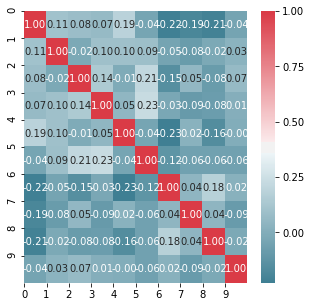

In [188]:
heatMap(pd.DataFrame(R_tot_f))

In [28]:
R_flat=R
r=R[:,:,1]

R_gf=np.zeros((r.flatten().shape[0],R.shape[2]))
for i in range(R.shape[2]):
    r=R[:,:,i].flatten()
    R_gf[:,i]=r
    
R_gf.shape    

(1140, 10)

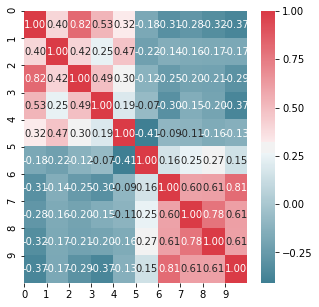

In [112]:
prix_a_test=prix_a[N_train:]
#heatMap(pd.DataFrame(R_gf))
heatMap(get_return(pd.DataFrame(prix_a_test)))


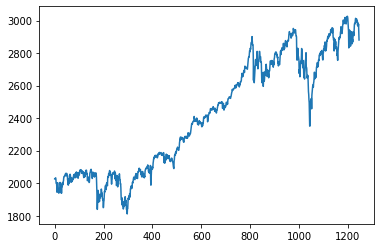

In [89]:
plt.plot(prix_a_test[:,3])

In [31]:
def aff_autocorr(n_lag,s):
    A=[]

    for k in range(0,n_lag+1):
        A.append(s.autocorr(lag=k))

    Ad=pd.Series(A)
    x=np.array([i for i in range(0,n_lag+1)])
    plt.plot(x,A)
    plt.xlabel('lag')
    plt.ylabel('ACF')

In [ ]:
R_m=np.mean(R,axis=0)
R_m.shape